Import Packages 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format="retina"
import numpy as np
from PIL import Image
import pickle
import os
import cv2
import random
import time
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import math
from IPython import display
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import torch.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
import pdb
import ast

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"you are using {device}")

you are using cuda:0


In [2]:
base_color_tags = ["red", "orange", "yellow", "Tangerine", "dark", "black", "lavender", "lav", "brown", "copper", "cream", "white", "creamy", "olive", "red base", "halloween"]  #"axanthic"
base_color_labels = ["red", "yellow", "dark", "lavender", "cream", "olive"]

We want to sort the raw tags from scraping, the ones listed in `base_color_tags` to fit the tags we want to classify into: `base_color_labels`. For this `dark` covers `black`, `brown`; `red` covers `copper`; `lavender` covers `lav`; and `cream` covers `creamy` and `white`. 

Load the dataset from csv:

In [3]:
gecko_traits = pd.read_csv("trait-image.csv")

# Clean data up a bit
index = 0
for item in gecko_traits["Tag"]:
    item = ast.literal_eval(item) # convert sting to list
    new_item = []
    for tag in item:
        tag = tag.lower() # convert to lowercase
        new_item.append(tag)
    gecko_traits.loc[index, "Tag"] = new_item
    index += 1

gecko_traits.to_csv("gecko_by_traits.csv")  
gecko_traits

,Tag,Image Name
0,[phantom],2123697.jpeg
1,"[pinstripe, dark]",2702167.jpeg
2,"[dalmatian, super dalmatian, ink spot, red spo...",2702191.jpeg
3,[buckskin],2571629.jpeg
4,"[dalmatian, harlequin, yellow]",2077235.jpeg
...,...,...
5920,"[pin-dashed, red base]",1616388.jpeg
5921,[harlequin],2398217.jpeg
5922,"[brindle, dalmatian]",2673233.jpeg
5923,"[flame, tri-color]",2662688.jpeg


## Data-Cleaning & Preprocessing

To Train the base color classification part of the model, we need to make a dataset that tags them by color:

In [4]:
new = []

for index, row in gecko_traits.iterrows():
    tags = row["Tag"]
    image_name = row["Image Name"]
    color = []
    traits = []
    addit = False

    for tag in tags:
        if tag in base_color_tags: # get base color traits
            color.append(tag)
            addit = True
        else: # get pattern traits
            traits.append(tag)

    if addit: # add to new dataframe for base color training
        new.append({"Color": color, "Traits": traits, "Image Name": image_name})

geckos_by_color = pd.DataFrame(new)
geckos_by_color

,Color,Traits,Image Name
0,[dark],[pinstripe],2702167.jpeg
1,[red],"[dalmatian, super dalmatian, ink spot, red spot]",2702191.jpeg
2,[yellow],"[dalmatian, harlequin]",2077235.jpeg
3,"[cream, black, dark]",[extreme harlequin],1563067.jpeg
4,[red],[harlequin],2702154.jpeg
...,...,...,...
3182,[orange],"[brindle, harlequin, portholes]",1967252.jpeg
3183,"[cream, yellow]",[harlequin],1880987.jpeg
3184,[red],"[dalmatian, portholes, bi-color]",1880952.jpeg
3185,[red base],[pin-dashed],1616388.jpeg


Normalize Color labels as described above. 

In [5]:
redundants = ["black", "lav", "brown", "orange", "copper", "white", "creamy", "red base", "halloween", "Tangerine"]
index = 0

for item in geckos_by_color["Color"]:
    tags_ind = 0
    tags = geckos_by_color.loc[index, "Color"]
    for tag in item:
        if tag in redundants:
            if tag in ["black", "brown", "halloween"]:
                tags[tags_ind] = "dark"
            elif tag in ["lav"]:
                tags[tags_ind] = "lavender"
            elif tag in ["copper", "orange", "red base", "tangerine"]:
                tags[tags_ind] = "red"
            elif tag in ["white", "creamy"]:
                tags[tags_ind] = "cream"
        tags_ind += 1
    geckos_by_color.loc[index, "Color"] = list(np.unique(np.array(tags)))
    index += 1


geckos_by_color.to_csv("gecko_by_color.csv")
geckos_by_color

,Color,Traits,Image Name
0,[dark],[pinstripe],2702167.jpeg
1,[red],"[dalmatian, super dalmatian, ink spot, red spot]",2702191.jpeg
2,[yellow],"[dalmatian, harlequin]",2077235.jpeg
3,"[cream, dark]",[extreme harlequin],1563067.jpeg
4,[red],[harlequin],2702154.jpeg
...,...,...,...
3182,[red],"[brindle, harlequin, portholes]",1967252.jpeg
3183,"[cream, yellow]",[harlequin],1880987.jpeg
3184,[red],"[dalmatian, portholes, bi-color]",1880952.jpeg
3185,[red],[pin-dashed],1616388.jpeg


Translate to one-hot encoding

In [6]:
color_lists = geckos_by_color.explode("Color")
one_hotted = pd.get_dummies(color_lists, columns=["Color"], prefix='', prefix_sep='')
one_hot_color = one_hotted.groupby(level=0).sum()
one_hot_color["Image Name"] = geckos_by_color["Image Name"].values

one_hot_color.to_csv("gecko_by_color_onehot.csv")
one_hot_color

,Traits,Image Name,cream,dark,lavender,olive,red,yellow
0,[pinstripe],2702167.jpeg,0,1,0,0,0,0
1,"[dalmatian, super dalmatian, ink spot, red spot]",2702191.jpeg,0,0,0,0,1,0
2,"[dalmatian, harlequin]",2077235.jpeg,0,0,0,0,0,1
3,"[extreme harlequin, extreme harlequin]",1563067.jpeg,1,1,0,0,0,0
4,[harlequin],2702154.jpeg,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
3182,"[brindle, harlequin, portholes]",1967252.jpeg,0,0,0,0,1,0
3183,"[harlequin, harlequin]",1880987.jpeg,1,0,0,0,0,1
3184,"[dalmatian, portholes, bi-color]",1880952.jpeg,0,0,0,0,1,0
3185,[pin-dashed],1616388.jpeg,0,0,0,0,1,0


Create distribution dataset as well, another form of data representation where if we have a gecko with cream: 1 and red: 1, we turn that into cream: 0.5 and red: 0.5 instead.

In [7]:
new = []
multis = 0
for index, row in one_hot_color.iterrows():
    colors_raw = np.array(row[2:])
    denom = np.sum(colors_raw)
    colors = colors_raw / denom
    if denom > 1:
        multis += 1
        #print(f"hey : {denom}")
    colors_raw /= 1
    #print(colors)
    new.append({"Image Name": row["Image Name"], 
                "Cream": colors[0], 
                "Dark": colors[1],
                "Lavender": colors[2],
                "Olive": colors[3],
                "Red": colors[4],
                "Yellow": colors[5],
                "Colors Raw": list(colors),
                "Colors Hot": list(colors_raw),
                "Traits": row["Traits"]
                })
    
distr_color = pd.DataFrame(new)

distr_color.to_csv("gecko_by_color_distr.csv")

def drop_rows(dataframe, image_names):
    return dataframe[~dataframe['Image Name'].isin(image_names)]

image_names_to_drop = ['2398217.jpeg', '2662688.jpeg', '2673233.jpeg', '2523692.jpeg']

distr_color = drop_rows(distr_color, image_names_to_drop)
print(multis)

distr_color

505


,Image Name,Cream,Dark,Lavender,Olive,Red,Yellow,Colors Raw,Colors Hot,Traits
0,2702167.jpeg,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",[pinstripe]
1,2702191.jpeg,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[dalmatian, super dalmatian, ink spot, red spot]"
2,2077235.jpeg,0.0,0.0,0.0,0.0,0.0,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[dalmatian, harlequin]"
3,1563067.jpeg,0.5,0.5,0.0,0.0,0.0,0.0,"[0.5, 0.5, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[extreme harlequin, extreme harlequin]"
4,2702154.jpeg,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",[harlequin]
...,...,...,...,...,...,...,...,...,...,...
3181,2083303.jpeg,0.0,0.5,0.0,0.0,0.5,0.0,"[0.0, 0.5, 0.0, 0.0, 0.5, 0.0]","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0]","[partial pinstripe, partial pinstripe]"
3182,1967252.jpeg,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[brindle, harlequin, portholes]"
3183,1880987.jpeg,0.5,0.0,0.0,0.0,0.0,0.5,"[0.5, 0.0, 0.0, 0.0, 0.0, 0.5]","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[harlequin, harlequin]"
3184,1880952.jpeg,0.0,0.0,0.0,0.0,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[dalmatian, portholes, bi-color]"


In [8]:
def presence_in(dataframe):
    creams = 0
    darks = 0
    lavenders = 0
    olives = 0
    reds = 0
    yellows = 0
    for index, row in dataframe.iterrows():
        if row["Cream"] > 0:
            creams += 1
        if row["Dark"] > 0:
            darks += 1
        if row["Lavender"] > 0:
            lavenders += 1
        if row["Olive"] > 0:
            olives += 1
        if row["Red"] > 0:
            reds += 1
        if row["Yellow"] > 0:
            yellows += 1

    print(f"Creams: {creams}, Darks: {darks}, Lavenders: {lavenders}, Olives: {olives}, Reds: {reds}, Yellows: {yellows}")

presence_in(distr_color)

Creams: 497, Darks: 922, Lavenders: 329, Olives: 34, Reds: 1261, Yellows: 688


In [55]:
perm = torch.randperm(784)
random.seed(time.time())
train_df, val_df = train_test_split(distr_color, test_size=0.2, random_state=random.randint(0, 100))
train_df, test_df = train_test_split(train_df, test_size=0.1, random_state=random.randint(0, 100))
print(len(train_df), len(val_df), len(test_df))

presence_in(train_df)
presence_in(val_df)
presence_in(test_df)

2293 638 255
Creams: 349, Darks: 653, Lavenders: 233, Olives: 25, Reds: 911, Yellows: 503
Creams: 106, Darks: 186, Lavenders: 76, Olives: 6, Reds: 251, Yellows: 131
Creams: 42, Darks: 83, Lavenders: 20, Olives: 3, Reds: 99, Yellows: 54


### Data Equalization

Method 1 for equalizing class labels in dataset, this should help with equal predictions

In [56]:
def count_non_zero(items):
    return sum(1 for item in items if item > 0)

multi_df = train_df[train_df["Colors Hot"].apply(count_non_zero) > 1]
mask_crm = train_df["Cream"] == 1
cream_df = train_df[mask_crm]
mask_drk = train_df["Dark"] == 1
dark_df = train_df[mask_drk]
mask_lav = train_df["Lavender"] == 1
lav_df = train_df[mask_lav]
mask_olv = train_df["Olive"] == 1
olive_df = train_df[mask_olv]
mask_red = train_df["Red"] == 1
red_df = train_df[mask_red]
mask_yel = train_df["Yellow"] == 1
yellow_df = train_df[mask_yel]

print(len(cream_df), len(dark_df), len(lav_df), len(olive_df), len(red_df), len(yellow_df), len(multi_df))

presence_in(multi_df)
targets = 10000 // 7

def equalize_frame(dataframe, targets):
    iterate = targets // len(dataframe)
    #print(iterate)
    leftover = targets % len(dataframe)
    #print(iter, leftover)
    df_copy = dataframe.copy()
    for i in range(iterate - 1):
        dataframe = pd.concat([dataframe, df_copy])

    if (len(dataframe) > targets):
        dataframe = dataframe.head(600)
        return dataframe
    
    elif leftover > 0:
        dataframe = pd.concat([dataframe, df_copy.head(leftover)])
    return dataframe

#cream_df = equalize_frame(cream_df, targets) #+ 105)
#dark_df = equalize_frame(dark_df, targets) #+ 320)
#lav_df = equalize_frame(lav_df, targets) #+ 1124)
#olive_df = equalize_frame(olive_df, targets) #+ 1520)
#red_df = equalize_frame(red_df, targets) # + 418)
#yellow_df = equalize_frame(yellow_df, targets) #+ 948)

cream_df = equalize_frame(cream_df, 550)
dark_df = equalize_frame(dark_df, 600)
lav_df = equalize_frame(lav_df, 600)
olive_df = equalize_frame(olive_df, 600)
yellow_df = equalize_frame(yellow_df, 600)
red_df = equalize_frame(red_df, 1)
#multi_df = equalize_frame(multi_df, 8000)

print(len(cream_df), len(dark_df), len(lav_df), len(olive_df), len(red_df), len(yellow_df)), #len(multi_df))

train_df = pd.concat([cream_df, dark_df, lav_df, olive_df, red_df, yellow_df, multi_df])

presence_in(train_df)

print(len(multi_df))
print(len(train_df))

#df_cleaned = multi_df

141 474 164 17 746 400 351
Creams: 208, Darks: 179, Lavenders: 69, Olives: 8, Reds: 165, Yellows: 103
550 600 600 600 600 600
Creams: 758, Darks: 779, Lavenders: 669, Olives: 608, Reds: 765, Yellows: 703
351
3901


Equalize the train and validation sets

In [57]:
print(len(test_df))
presence_in(test_df)

multi_df = test_df[test_df["Colors Hot"].apply(count_non_zero) > 1]
mask_crm = test_df["Cream"] == 1
cream_df = test_df[mask_crm]
mask_drk = test_df["Dark"] == 1
dark_df = test_df[mask_drk]
mask_lav = test_df["Lavender"] == 1
lav_df = test_df[mask_lav]
mask_olv = test_df["Olive"] == 1
olive_df = test_df[mask_olv]
mask_red = test_df["Red"] == 1
red_df = test_df[mask_red]
mask_yel = test_df["Yellow"] == 1
yellow_df = test_df[mask_yel]

cream_df = equalize_frame(cream_df, 100)
dark_df = equalize_frame(dark_df, 100)
lav_df = equalize_frame(lav_df, 100)
olive_df = equalize_frame(olive_df, 100)
red_df = equalize_frame(red_df, 100)
yellow_df = equalize_frame(yellow_df, 100)

test_df = pd.concat([cream_df, dark_df, lav_df, olive_df, red_df, yellow_df, multi_df])

presence_in(test_df)
print(len(test_df))

print(len(val_df))
presence_in(val_df)

multi_df = val_df[val_df["Colors Hot"].apply(count_non_zero) > 1]
mask_crm = val_df["Cream"] == 1
cream_df = val_df[mask_crm]
mask_drk = val_df["Dark"] == 1
dark_df = val_df[mask_drk]
mask_lav = val_df["Lavender"] == 1
lav_df = val_df[mask_lav]
mask_olv = val_df["Olive"] == 1
olive_df = val_df[mask_olv]
mask_red = val_df["Red"] == 1
red_df = val_df[mask_red]
mask_yel = val_df["Yellow"] == 1
yellow_df = val_df[mask_yel]

cream_df = equalize_frame(cream_df, 250)
dark_df = equalize_frame(dark_df, 250)
lav_df = equalize_frame(lav_df, 250)
olive_df = equalize_frame(olive_df, 250)
red_df = equalize_frame(red_df, 250)
yellow_df = equalize_frame(yellow_df, 250)

val_df = pd.concat([cream_df, dark_df, lav_df, olive_df, red_df, yellow_df, multi_df])

presence_in(val_df)
print(len(val_df))

255
Creams: 42, Darks: 83, Lavenders: 20, Olives: 3, Reds: 99, Yellows: 54
Creams: 128, Darks: 119, Lavenders: 108, Olives: 102, Reds: 122, Yellows: 110
643
638
Creams: 106, Darks: 186, Lavenders: 76, Olives: 6, Reds: 251, Yellows: 131
Creams: 319, Darks: 314, Lavenders: 271, Olives: 251, Reds: 305, Yellows: 269
1611


Equalizing dataset for multi-colored geckos

In [ ]:
print(len(multi_df))

multi_df.iloc[:, 1:-3] = multi_df.iloc[:, 1:-3].applymap(lambda x: 1 if x > 0 else x)

mask = multi_df["Cream"] > 0
multi_cream_df = multi_df[mask]
mask = multi_df["Dark"] > 0
multi_dark_df = multi_df[mask]
mask = multi_df["Lavender"] > 0
multi_lav_df = multi_df[mask]
mask = multi_df["Olive"] > 0
multi_olive_df = multi_df[mask]
mask = multi_df["Red"] > 0
multi_red_df = multi_df[mask]
mask = multi_df["Yellow"] > 0
multi_yellow_df = multi_df[mask]
print(len(multi_cream_df), len(multi_dark_df), len(multi_lav_df), len(multi_olive_df), len(multi_red_df), len(multi_yellow_df))

presence_in(multi_df)

targets = 10000 // 7

multi_cream_df = equalize_frame(multi_cream_df, targets) #+ 105)
multi_dark_df = equalize_frame(multi_dark_df, 262) #+ 320)
multi_lav_df = equalize_frame(multi_lav_df, targets + 5032) #+ 1124)
multi_olive_df = equalize_frame(multi_olive_df, targets + 7000) #+ 1520)
multi_red_df = equalize_frame(multi_red_df, targets + 1200) # + 418)
multi_yellow_df = equalize_frame(multi_yellow_df, targets + 5000) #+ 948)

multi_df_new =  pd.concat([multi_cream_df, multi_dark_df, multi_lav_df, multi_olive_df, multi_red_df, multi_yellow_df]) 

presence_in(multi_df_new)
print(len(multi_df_new))


103
62 54 22 4 50 25
Creams: 62, Darks: 54, Lavenders: 22, Olives: 4, Reds: 50, Yellows: 25


C:\Users\Ari Sinervo\AppData\Local\Temp\ipykernel_7100\2825906171.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  multi_df.iloc[:, 1:-3] = multi_df.iloc[:, 1:-3].applymap(lambda x: 1 if x > 0 else x)


Creams: 9375, Darks: 10463, Lavenders: 8151, Olives: 8700, Reds: 7277, Yellows: 10447
25634


#### bad labels equalizer

Method 2 for equalizing class presence in data

In [ ]:


target = 10000 - len(distr_color)
print(f"target: {target}")
presence = [distr_color["Cream"].sum(), distr_color["Dark"].sum(), distr_color["Lavender"].sum(), distr_color["Olive"].sum(), distr_color["Red"].sum(), distr_color["Yellow"].sum()]
print(presence)

mask_crm = distr_color["Cream"] == 1
cream_df = distr_color[mask_crm]
mask_drk = distr_color["Dark"] == 1
dark_df = distr_color[mask_drk]
mask_lav = distr_color["Lavender"] == 1
lav_df = distr_color[mask_lav]
mask_olv = distr_color["Olive"] == 1
olive_df = distr_color[mask_olv]
mask_red = distr_color["Red"] == 1
red_df = distr_color[mask_red]
mask_yel = distr_color["Yellow"] == 1
yellow_df = distr_color[mask_yel]

mask_olp = mask_crm | mask_drk | mask_lav | mask_olv | mask_red | mask_yel
overlap_df = distr_color[mask_olp]

#print(cream_df)




print(multis)
print(len(cream_df)+len(dark_df)+len(lav_df)+len(olive_df)+len(red_df)+len(yellow_df)+multis)
#print(len(overlap_df) == len(distr_color))
#print(len(overlap_df))

num_cream = (len(cream_df) / len(distr_color) * 10000)
num_dark = (len(dark_df) / len(distr_color) * 10000)
num_lavender = (len(lav_df) / len(distr_color) * 10000)
num_olive = (len(olive_df) / len(distr_color) * 10000)
num_red = (len(red_df) / len(distr_color) * 10000)
num_yellow = (len(yellow_df) / len(distr_color) * 10000)

targ = 10000 // 6 

new_cream_df = cream_df
length = len(cream_df)
for i in range(int(targ // num_cream) * 4 + 1):
    if i >= 0:
        cream_df = pd.concat([cream_df, new_cream_df])

new_dark_df = dark_df
length = len(dark_df)
for i in range(int(targ // num_dark) + 1):
    if i >= 0:
        dark_df = pd.concat([dark_df, new_dark_df])

new_lav_df = lav_df
length = len(lav_df)
for i in range(int(targ // num_lavender) * 4):
    if i >= 0:
        lav_df = pd.concat([lav_df, new_lav_df])

new_olive_df = olive_df
length = len(olive_df)
for i in range(int(targ // num_olive) * 4):
    if i >= 0:
        olive_df = pd.concat([olive_df, new_olive_df])

new_red_df = red_df
length = len(red_df)
for i in range(int(targ // num_red) * 2):
    if i > 0: 
        red_df = pd.concat([red_df, new_red_df])

new_yellow_df = yellow_df
length = len(yellow_df)
for i in range(int(targ // num_yellow) + 2):
    if i >= 0:
        yellow_df = pd.concat([yellow_df, new_yellow_df])

print(len(cream_df))
print(len(dark_df))
print(len(lav_df))
print(len(olive_df))
print(len(red_df))
print(len(yellow_df))


"""for i in range num_cream / len(cream_df):
    cream_df = pd.concat([cream_df, cream_df])"""

print(f"num_cream: {num_cream}")

df_cleaned_2 = pd.concat([cream_df, dark_df, lav_df, olive_df, red_df, yellow_df, overlap_df])
print(len(df_cleaned_2))
presence = [df_cleaned_2["Cream"].sum(), df_cleaned_2["Dark"].sum(), df_cleaned_2["Lavender"].sum(), df_cleaned_2["Olive"].sum(), df_cleaned_2["Red"].sum(), df_cleaned_2["Yellow"].sum()]
print(presence)

target: 6814
[339.8666666666667, 786.8666666666667, 276.3666666666667, 28.333333333333332, 1135.6999999999998, 618.8666666666667]
505
3186
1920
1320
2079
2139
1019
1668
num_cream: 602.6365348399246
12826
[2112.0, 1980.0, 2310.0, 2162.0, 2038.0, 2224.0]


### Data Padding

Pad dataset with blanks and copies to push model away from always predicting true

In [39]:
def pad_data(dataframe, factor):
    df_copy = dataframe.copy()
    for i in range(factor):
        dataframe = pd.concat([dataframe, df_copy])
    return dataframe

train_df = pad_data(train_df, 1)
test_df = pad_data(test_df, 1)
print(len(train_df), len(test_df))

14200 2400


In [ ]:
presence_in(train_df)
presence_in(test_df)

Creams: 6568, Darks: 5320, Lavenders: 4552, Olives: 1656, Reds: 7152, Yellows: 4048
Creams: 2496, Darks: 2400, Lavenders: 2168, Olives: 2032, Reds: 2400, Yellows: 2240


In [ ]:
#distr_color.loc[distr_color["Image Name"] == "2523692.jpeg"]
#df_cleaned.loc[df_cleaned["Image Name"] == "2523692.jpeg"]
#train_df.loc[train_df["Image Name"] == "2262462.jpeg"]

,Image Name,Cream,Dark,Lavender,Olive,Red,Yellow,Colors Raw,Colors Hot,Traits


#### Test With CIFAR10

100%|██████████| 170M/170M [01:32<00:00, 1.84MB/s] 


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


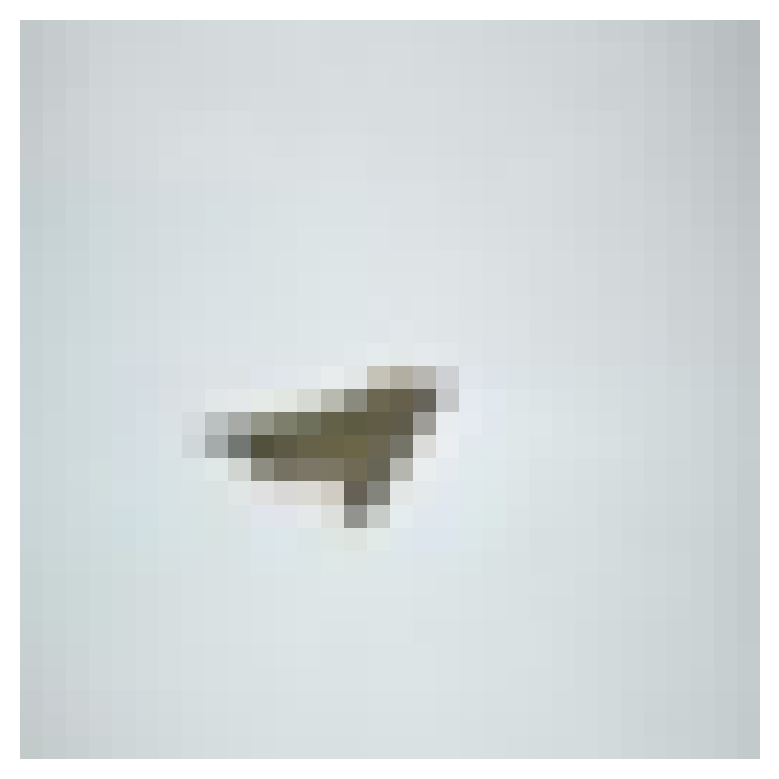

In [ ]:
train_dataset = datasets.CIFAR10(root="data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root="data", train=False, download=True, transform=transforms.ToTensor())
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

image, _ = trainloader.dataset.__getitem__(0)
image = image.permute(1,2,0)
plt.imshow(image, cmap=plt.cm.binary)
plt.axis('off');

### Data Loading

Create a method to turn dataframe into dataloader

In [58]:
im_size = 128
if im_size == 396:
    imm_string = ""
else:
    imm_string = str(im_size) + "x" + str(im_size)

class DataFromFrame(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.tfm = transform
        self.len = len(self.df)

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        image_name = row["Image Name"]
        image = Image.open(f"data/MajorImages{imm_string}/images/{image_name}")
        label = row["Colors Hot"]

        if self.tfm:
            image = self.tfm(image)

        return image, torch.tensor(label)

def Df_Loader(df, batch_size=2, shuffle=True, transform=transforms.ToTensor()):
    return torch.utils.data.DataLoader(DataFromFrame(df, transform=transform), batch_size=batch_size, shuffle=shuffle)

In [59]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    incr = 0.
    for data, _ in loader:
        batch_data = data.size(0)
        data = data.view(batch_data, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        incr += batch_data

    mean /= incr
    std /= incr
    return mean, std

#inter_loader = Df_Loader(train_df, batch_size=2, shuffle=False)
#print(len(inter_loader))
#mean, std = get_mean_std(inter_loader)
#print(mean, std)

class FixedContrastTransform:
    def __init__(self, contrast_factor):
        self.contrast_factor = contrast_factor

    def __call__(self, img):
        return transforms.functional.adjust_contrast(img, self.contrast_factor)


In [90]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=(im_size, im_size), scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    FixedContrastTransform(2.5),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    #transforms.Normalize(mean=mean, std=std)
])

transform_test = transforms.Compose([
    transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    FixedContrastTransform(2.5),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


3901 1611 643


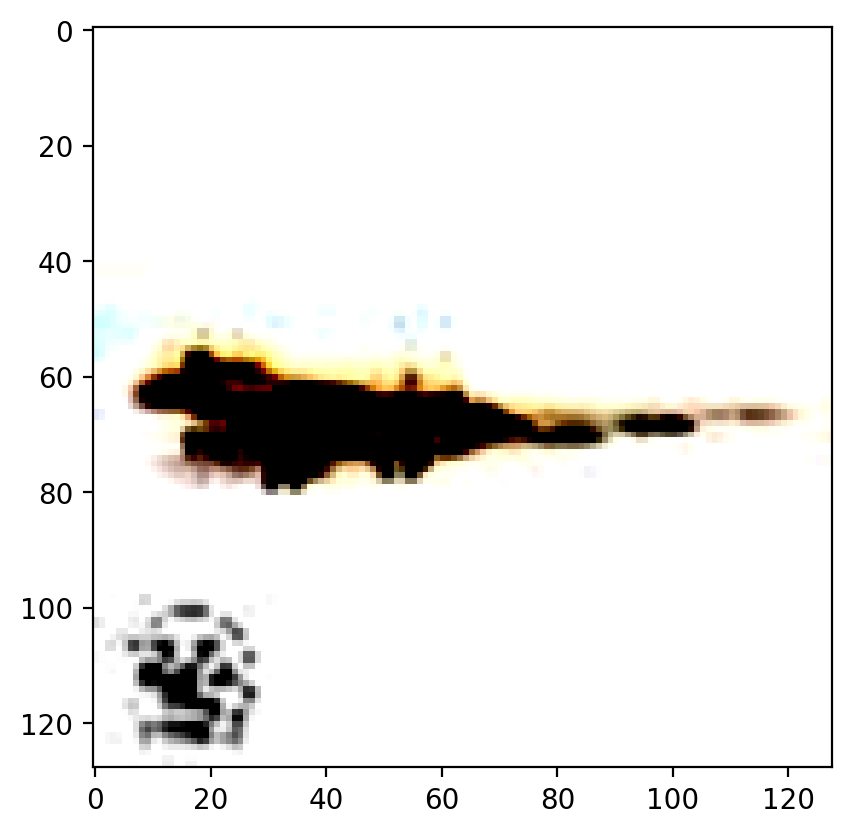

In [91]:
perm = torch.randperm(784)
random.seed(time.time())
#train_df, test_df = train_test_split(df_cleaned, test_size=0.2, random_state=random.randint(0, 100))
#train_df, test_df = train_test_split(distr_color, test_size=0.2, random_state=random.randint(0, 100))
#train_df, val_df = train_test_split(df_cleaned, test_size=0.1, random_state=random.randint(0, 100))
#test_df = drop_rows(test_df, image_names_to_drop)
#print(len(train_df), len(test_df))
#print(len(train_df), len(val_df), len(test_df))
#val_df = val_df.iloc[:-4]
print(len(train_df), len(val_df), len(test_df))

batch_size = 32
gecko_dataloader_train = Df_Loader(train_df, batch_size=batch_size, shuffle=True, transform=transform_train)
gecko_dataloader_val = Df_Loader(val_df, batch_size=batch_size, shuffle=True, transform=transform_test)
gecko_dataloader_test = Df_Loader(test_df, batch_size=batch_size, shuffle=True, transform=transform_test)


image, _ = gecko_dataloader_val.dataset.__getitem__(0)
image = image.permute(1,2,0)
plt.imshow(image, cmap=plt.cm.binary)

## Model Definition

In [85]:
from torchvision import models

class pretrained(nn.Module):
    def __init__(self, num_classes):
        super(pretrained, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        x = self.model(x)
        return x
    
class untrained(nn.Module):
    def __init__(self, num_classes):
        super(untrained, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
    
    def forward(self, x):
        x = self.model(x)
        return x

In [34]:

class Gecko_Color_Alpha(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Alpha, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.elu1 = nn.ELU()

        self.conv2 = nn.Conv2d(128, 192, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.elu2 = nn.ELU()

        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.elu3 = nn.ELU()
        
        conv_size = im_size // 2 // 2 // 2 
        self.fc1 = nn.Linear(384 * conv_size * conv_size, 196)
        self.bn4 = nn.BatchNorm1d(196)
        self.fc2 = nn.Linear(196, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool1(self.elu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.elu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.elu3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.bn4(self.fc1(x)))
        x = nn.functional.relu(self.bn5(self.fc2(x)))
        x = nn.functional.softmax(self.fc3(x))
        return x

In [19]:
class residual_skip2d(nn.Module):
    def __init__(self, ins, outs, kernel_size=3, stride=1, padding=1, dropout=0.0):
        super(residual_skip2d, self).__init__()
        self.conv1 = nn.Conv2d(ins, outs, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm2d(outs)
            
        self.conv2 = nn.Conv2d(outs, outs, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(outs)
        self.elu = nn.ELU()
        self.dropout = nn.Dropout(dropout)

        self.shortcut = nn.Sequential()

        if ins != outs:
            self.shortcut = nn.Sequential(
                nn.Conv2d(ins, outs, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(outs)
            )

    def forward(self, x):
        res = x
        x = self.elu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = self.elu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x += self.shortcut(res)
        x = self.elu(x)
        return x
    
class Gecko_Color_Res(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Res, self).__init__()
        self.conv1 = residual_skip2d(3, 128, kernel_size=3, stride=1, padding=1, dropout=0.0)

        self.conv2 = residual_skip2d(32, 64, kernel_size=3, stride=1, padding=1, dropout=0.0)

        self.conv3 = residual_skip2d(64, 128, kernel_size=3, stride=1, padding=1, dropout=0.0)

        #self.conv4 = residual_skip2d(128, 256, kernel_size=3, stride=1, padding=1, dropout=0.2)

        #self.conv5 = residual_skip2d(256, 512, kernel_size=3, stride=1, padding=1, dropout=0.25)

        self.global_pool = nn.MaxPool2d(2,2)

        conv_size = im_size // ( 2 ** 1)
        self.fc1 = nn.Linear(128 * conv_size * conv_size, 512)#1024)
        #self.bnFC1 = nn.BatchNorm1d(512)
        self.dropoutFC1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 128)
        #self.bnFC2 = nn.BatchNorm1d(128)
        self.dropoutFC2 = nn.Dropout(0.4)

        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        #print(f"Layer 0 size : {x.size()}")
        #x = self.conv1(x)

        #print(f"Layer 1 size : {x.size()}")
        x = self.global_pool(self.conv1(x))

        #print(f"Layer 2 size : {x.size()}")
        #x = self.global_pool(self.conv3(x))

        #print(f"Layer 3 size : {x.size()}")
        #x = self.global_pool(self.conv4(x))

        #print(f"Layer 4 size : {x.size()}")
        #x = self.global_pool(self.conv5(x))

        #print(f"Layer 5 size : {x.size()}")
        x = x.view(x.size(0), -1)
        
        #print(f"FC Layer 0 size : {x.size()}")
        x = nn.functional.relu(self.fc1(x))
        x = self.dropoutFC1(x)

        #print(f"FC Layer 1 size : {x.size()}")
        x = nn.functional.relu(self.fc2(x))
        x = self.dropoutFC2(x)

        #print(f"FC Layer 2 size : {x.size()}")
        x = self.fc4(x)
        #x = nn.functional.softmax(self.fc4(x))
        return x

In [20]:
class ConvNet2(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.05) #0.2

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.05) #0.2

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.elu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.1) #0.2

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.elu4 = nn.ELU()
        self.dropout4 = nn.Dropout(0.15) #0.3

        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.elu5 = nn.ELU()
        self.dropout5 = nn.Dropout(0.15) #0.3

        self.globalpool = nn.MaxPool2d(2,2)

        conv_size = im_size // 2 // 2 
        self.fc1 = nn.Linear(512 * conv_size * conv_size, 512)#1024)
        #self.bnFC1 = nn.BatchNorm1d(512)
        self.dropoutFC1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(512, 128)
        #self.bnFC2 = nn.BatchNorm1d(128)
        self.dropoutFC2 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        #print(f"Layer 0 size : {x.size()}")
        x = (self.elu1(self.bn1(self.conv1(x))))
        #x = self.dropout1(x)

        #print(f"Layer 1 size : {x.size()}")
        x = (self.elu2(self.bn2(self.conv2(x))))
        #x = self.dropout2(x)

        #print(f"Layer 2 size : {x.size()}")
        x = self.globalpool(self.elu3(self.bn3(self.conv3(x))))
        #x = self.dropout3(x)

        #print(f"Layer 3 size : {x.size()}")
        x = (self.elu4(self.bn4(self.conv4(x))))
        #x = self.dropout4(x)

        #print(f"Layer 4 size : {x.size()}")
        x = self.globalpool(self.elu5(self.bn5(self.conv5(x))))
        #x = self.dropout5(x)

        #print(f"Layer 5 size : {x.size()}")
        x = x.view(x.size(0), -1)
        
        #print(f"FC Layer 0 size : {x.size()}")
        x = nn.functional.relu(self.fc1(x))
        #x = self.dropoutFC1(x)

        #print(f"FC Layer 1 size : {x.size()}")
        x = nn.functional.relu(self.fc2(x))
        #x = self.dropoutFC2(x)

        #print(f"FC Layer 2 size : {x.size()}")
        x = self.fc4(x)
        #x = nn.functional.softmax(self.fc4(x))
        return x

In [21]:
class ConvNet3(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet3, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.05) #0.2

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.05) #0.2

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.elu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.1) #0.2

        self.globalpool = nn.MaxPool2d(2,2)

        conv_size = im_size // 2 
        self.fc1 = nn.Linear(128 * conv_size * conv_size, 512)#1024)
        #self.bnFC1 = nn.BatchNorm1d(512)
        self.dropoutFC1 = nn.Dropout(0.2)

        self.fc2 = nn.Linear(512, 128)
        #self.bnFC2 = nn.BatchNorm1d(128)
        self.dropoutFC2 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        #print(f"Layer 0 size : {x.size()}")
        x = (self.elu1(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        #print(f"Layer 1 size : {x.size()}")
        x = (self.elu2(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        #print(f"Layer 2 size : {x.size()}")
        x = self.globalpool(self.elu3(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        #print(f"Layer 5 size : {x.size()}")
        x = x.view(x.size(0), -1)
        
        #print(f"FC Layer 0 size : {x.size()}")
        x = nn.functional.relu(self.fc1(x))
        x = self.dropoutFC1(x)

        #print(f"FC Layer 1 size : {x.size()}")
        x = nn.functional.relu(self.fc2(x))
        x = self.dropoutFC2(x)

        #print(f"FC Layer 2 size : {x.size()}")
        x = self.fc4(x)
        #x = nn.functional.softmax(self.fc4(x))
        return x


#### ignore these:

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.15)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.15)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.elu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.25)

        conv_size = im_size // 2 // 2 // 2
        self.fc1 = nn.Linear(128 * conv_size * conv_size, 196)
        self.bnFC1 = nn.BatchNorm1d(196)
        self.dropoutFC1 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(196, 128)
        self.bnFC2 = nn.BatchNorm1d(128)
        self.dropoutFC2 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 128)
        self.bnFC3 = nn.BatchNorm1d(128)
        self.dropoutFC3 = nn.Dropout(0.25)

        self.fc4 = nn.Linear(128, 6)

    def forward(self, x):
        #print(f"Layer 0 size : {x.size()}")
        x = self.pool1(self.elu1(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        #print(f"Layer 1 size : {x.size()}")
        x = self.pool2(self.elu2(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        #print(f"Layer 2 size : {x.size()}")
        x = self.pool3(self.elu3(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        
        #print(f"Layer 5 size : {x.size()}")
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.bnFC1(self.fc1(x)))
        x = self.dropoutFC1(x)

        #print(f"FC Layer 1 size : {x.size()}")
        x = nn.functional.relu(self.bnFC2(self.fc2(x)))
        x = self.dropoutFC2(x)

        #x = nn.functional.relu(self.bnFC3(self.fc3(x)))
        #x = self.dropoutFC3(x)

        #print(f"FC Layer 2 size : {x.size()}")
        x = nn.functional.softmax(self.fc4(x))
        return x

In [ ]:
class Gecko_Color_Alpha_Simple(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Alpha_Simple, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.15)

        self.conv2 = nn.Conv2d(128, 192, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.elu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.1)

        conv_size = im_size // 2 // 2 // 2
        self.fc1 = nn.Linear(384 * conv_size * conv_size, 196)
        self.bnFC1 = nn.BatchNorm1d(196)
        self.dropoutFC1 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(196, 128)
        self.bnFC2 = nn.BatchNorm1d(128)
        self.dropoutFC2 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        #print(f"Layer 0 size : {x.size()}")
        x = self.pool1(self.elu1(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        #print(f"Layer 1 size : {x.size()}")
        x = self.pool2(self.elu2(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        #print(f"Layer 2 size : {x.size()}")
        x = self.pool3(self.elu3(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        
        #print(f"Layer 5 size : {x.size()}")
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.bnFC1(self.fc1(x)))
        x = self.dropoutFC1(x)

        #print(f"FC Layer 1 size : {x.size()}")
        x = nn.functional.relu(self.bnFC2(self.fc2(x)))
        x = self.dropoutFC2(x)

        #print(f"FC Layer 2 size : {x.size()}")
        x = nn.functional.softmax(self.fc3(x))
        return x

"""class Gecko_Color_Alpha_Simple(nn.Module):
    def ___init___(self, num_classes):
        super(Gecko_Color_Alpha_Simple, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)"""

'class Gecko_Color_Alpha_Simple(nn.Module):\n    def ___init___(self, num_classes):\n        super(Gecko_Color_Alpha_Simple, self).__init__()\n        self.model = models.resnet18(pretrained=True)\n        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)\n\n    def forward(self, x):\n        return self.model(x)'

In [ ]:
class Gecko_Color_Beta(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Beta, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.1)

        self.conv2 = nn.Conv2d(128, 192, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.elu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.1)

        # ADDED AS TEST vvv
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.elu4 = nn.ELU()
        self.dropout4 = nn.Dropout(0.1)
        # ADDED AS TEST ^^^

        conv_size = im_size // 2 // 2 // 2 // 2
        self.fc1 = nn.Linear(256 * conv_size * conv_size, 196)
        self.bnFC1 = nn.BatchNorm1d(196)
        self.dropoutFC1 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(196, 128)
        self.bnFC2 = nn.BatchNorm1d(128)
        self.dropoutFC2 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        #print(f"Layer 0 size : {x.size()}")
        x = self.pool1(self.elu1(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        #print(f"Layer 1 size : {x.size()}")
        x = self.pool2(self.elu2(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        #print(f"Layer 2 size : {x.size()}")
        x = self.pool3(self.elu3(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        #print(f"Layer 3 size : {x.size()}")
        x = self.pool4(self.elu4(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        
        #print(f"Layer 4 size : {x.size()}")
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.bnFC1(self.fc1(x)))
        x = self.dropoutFC1(x)

        #print(f"FC Layer 1 size : {x.size()}")
        x = nn.functional.relu(self.bnFC2(self.fc2(x)))
        x = self.dropoutFC2(x)

        #print(f"FC Layer 2 size : {x.size()}")
        x = nn.functional.softmax(self.fc3(x))
        return x

In [ ]:
class Gecko_Color_Alpha1(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Alpha, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.15)

        self.conv2 = nn.Conv2d(128, 192, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.elu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.1)

        # ADDED AS TEST vvv
        self.conv4 = nn.Conv2d(384, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.elu4 = nn.ELU()
        self.dropout4 = nn.Dropout(0.1)

        self.conv5 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.elu5 = nn.ELU()
        self.dropout5 = nn.Dropout(0.1)
        # ADDED AS TEST ^^^

        conv_size = im_size // 2 // 2 // 2 // 2 // 2
        self.fc1 = nn.Linear(256 * conv_size * conv_size, 196)
        self.bnFC1 = nn.BatchNorm1d(196)
        self.dropoutFC1 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(196, 128)
        self.bnFC2 = nn.BatchNorm1d(128)
        self.dropoutFC2 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        #print(f"Layer 0 size : {x.size()}")
        x = self.pool1(self.elu1(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        #print(f"Layer 1 size : {x.size()}")
        x = self.pool2(self.elu2(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        #print(f"Layer 2 size : {x.size()}")
        x = self.pool3(self.elu3(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        #print(f"Layer 3 size : {x.size()}")
        x = self.pool4(self.elu4(self.bn4(self.conv4(x))))
        x = self.dropout4(x)

        #print(f"Layer 4 size : {x.size()}")
        x = self.pool5(self.elu5(self.bn5(self.conv5(x))))
        x = self.dropout5(x)
        
        #print(f"Layer 5 size : {x.size()}")
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.bnFC1(self.fc1(x)))
        x = self.dropoutFC1(x)

        #print(f"FC Layer 1 size : {x.size()}")
        x = nn.functional.relu(self.bnFC2(self.fc2(x)))
        x = self.dropoutFC2(x)

        #print(f"FC Layer 2 size : {x.size()}")
        x = nn.functional.softmax(self.fc3(x))
        return x

In [ ]:
class Gecko_Color_Alpha2(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Alpha1, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.4)

        self.conv2 = nn.Conv2d(128, 192, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv2d(192, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.elu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.4)

        self.conv4 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(384)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.elu4 = nn.ELU()
        self.dropout4 = nn.Dropout(0.15)

        # ADDED AS TEST vvv
        self.conv5 = nn.Conv2d(384, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.elu5 = nn.ELU()
        self.dropout5 = nn.Dropout(0.1)

        self.conv6 = nn.Conv2d(512, 768, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(768)
        self.pool6 = nn.MaxPool2d(2, 2)
        self.elu6 = nn.ELU()
        self.dropout6 = nn.Dropout(0.1)

        self.conv7 = nn.Conv2d(768, 512, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.pool7 = nn.MaxPool2d(2, 2)
        self.elu7 = nn.ELU()
        self.dropout7 = nn.Dropout(0.1)
        # ADDED AS TEST ^^^

        conv_size = im_size // 2 // 2 // 2 // 2 // 2 // 2 // 2
        self.fc1 = nn.Linear(512 * conv_size * conv_size, 196)
        self.bnFC1 = nn.BatchNorm1d(196)
        self.dropoutFC1 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(196, 128)
        self.bnFC2 = nn.BatchNorm1d(128)
        self.dropoutFC2 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        #print(f"Layer 0 size : {x.size()}")
        x = self.pool1(self.elu1(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        #print(f"Layer 1 size : {x.size()}")
        x = self.pool2(self.elu2(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        #print(f"Layer 2 size : {x.size()}")
        x = self.pool3(self.elu3(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        #print(f"Layer 3 size : {x.size()}")
        x = self.pool4(self.elu4(self.bn4(self.conv4(x))))
        x = self.dropout4(x)

        #print(f"Layer 4 size : {x.size()}")
        x = self.pool5(self.elu5(self.bn5(self.conv5(x))))
        x = self.dropout5(x)
        
        #print(f"Layer 5 size : {x.size()}")
        x = self.pool6(self.elu6(self.bn6(self.conv6(x))))
        x = self.dropout6(x)

        #print(f"Layer 6 size : {x.size()}")
        x = self.pool7(self.elu7(self.bn7(self.conv7(x))))
        x = self.dropout7(x)

        #print(f"Layer 7 size : {x.size()}")
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.bnFC1(self.fc1(x)))
        x = self.dropoutFC1(x)

        #print(f"FC Layer 1 size : {x.size()}")
        x = nn.functional.relu(self.bnFC2(self.fc2(x)))
        x = self.dropoutFC2(x)

        #print(f"FC Layer 2 size : {x.size()}")
        x = nn.functional.softmax(self.fc3(x))
        return x

The model below performs specifically worse than the basic alpha 1

In [ ]:
class Gecko_Color_Alpha3(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Alpha2, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(192)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.1)

        self.conv2 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(384)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv2d(384, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.elu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.1)

        # ADDED AS TEST vvv
        self.conv4 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.elu4 = nn.ELU()
        self.dropout4 = nn.Dropout(0.1)

        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.elu5 = nn.ELU()
        self.dropout5 = nn.Dropout(0.1)
        # ADDED AS TEST ^^^

        conv_size = im_size // 2 // 2 // 2 // 2 // 2
        self.fc1 = nn.Linear(128 * conv_size * conv_size, 196)
        self.bnFC1 = nn.BatchNorm1d(196)
        self.dropoutFC1 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(196, 128)
        self.bnFC2 = nn.BatchNorm1d(128)
        self.dropoutFC2 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        #print(f"Layer 0 size : {x.size()}")
        x = self.pool1(self.elu1(self.bn1(self.conv1(x))))
        x = self.dropout1(x)

        #print(f"Layer 1 size : {x.size()}")
        x = self.pool2(self.elu2(self.bn2(self.conv2(x))))
        x = self.dropout2(x)

        #print(f"Layer 2 size : {x.size()}")
        x = self.pool3(self.elu3(self.bn3(self.conv3(x))))
        x = self.dropout3(x)

        #print(f"Layer 3 size : {x.size()}")
        x = self.pool4(self.elu4(self.bn4(self.conv4(x))))
        x = self.dropout4(x)

        #print(f"Layer 4 size : {x.size()}")
        x = self.pool5(self.elu5(self.bn5(self.conv5(x))))
        x = self.dropout5(x)
        
        #print(f"Layer 5 size : {x.size()}")
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.bnFC1(self.fc1(x)))
        x = self.dropoutFC1(x)

        #print(f"FC Layer 1 size : {x.size()}")
        x = nn.functional.relu(self.bnFC2(self.fc2(x)))
        x = self.dropoutFC2(x)

        #print(f"FC Layer 2 size : {x.size()}")
        x = nn.functional.softmax(self.fc3(x))
        return x

In [ ]:
class Gecko_Color_Gamma(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Gamma, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.1)

        self.conv21 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.elu21 = nn.ELU()
        self.dropout21 = nn.Dropout(0.1)


        self.conv2 = nn.Conv2d(128, 192, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.1)

        self.conv22 = nn.Conv2d(192, 192, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.elu22 = nn.ELU()
        self.dropout22 = nn.Dropout(0.1)


        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.elu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.1)

        self.conv23 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.bn23 = nn.BatchNorm2d(384)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.elu23 = nn.ELU()
        self.dropout23 = nn.Dropout(0.1)


        self.conv4 = nn.Conv2d(384, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.elu4 = nn.ELU()
        self.dropout4 = nn.Dropout(0.1)

        self.conv24 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn24 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.elu24 = nn.ELU()
        self.dropout24 = nn.Dropout(0.1)


        self.conv5 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.elu5 = nn.ELU()
        self.dropout5 = nn.Dropout(0.1)

        self.conv25 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn25 = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.elu25 = nn.ELU()
        self.dropout25 = nn.Dropout(0.1)
        # ADDED AS TEST ^^^

        conv_size = im_size // 2 // 2 // 2 // 2 // 2
        self.fc1 = nn.Linear(256 * conv_size * conv_size, 196)
        self.bnFC1 = nn.BatchNorm1d(196)
        self.dropoutFC1 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(196, 128)
        self.bnFC2 = nn.BatchNorm1d(128)
        self.dropoutFC2 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 128)
        self.bnFC3 = nn.BatchNorm1d(128)
        self.dropoutFC3 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        #print(f"Layer 0 size : {x.size()}")
        #res1 = x
        x = self.elu1(self.bn1(self.conv1(x)))
        x = self.pool1(self.elu1(self.bn1(self.conv21(x))))
        x = self.dropout1(x)

        #res2 = x
        #print(f"Layer 1 size : {x.size()}")
        x = self.pool2(self.elu2(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        #x += res1

        #res3 = x
        #print(f"Layer 2 size : {x.size()}")
        x = self.pool3(self.elu3(self.bn3(self.conv3(x))))
        x = self.dropout3(x)
        #x += res2

        #res4 = x
        #print(f"Layer 3 size : {x.size()}")
        x = self.pool4(self.elu4(self.bn4(self.conv4(x))))
        x = self.dropout4(x)
        x += res3

        #res5 = x
        #prin  t(f"Layer 4 size : {x.size()}")
        x = self.pool5(self.elu5(self.bn5(self.conv5(x))))
        x = self.dropout5(x)
        x += res4

        #res6 = x

        #x += res5

        #print(f"Layer 5 size : {x.size()}")
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.bnFC1(self.fc1(x)))
        x = self.dropoutFC1(x)
        

        #print(f"FC Layer 1 size : {x.size()}")
        x = nn.functional.relu(self.bnFC2(self.fc2(x)))
        x = self.dropoutFC2(x)

        #print(f"FC Layer 2 size : {x.size()}")
        x = nn.functional.softmax(self.fc3(x))
        return x

In [ ]:
class Gecko_Color_Delta1(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Delta1, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.1)

        self.conv21 = nn.Conv2d(128, 3, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.elu21 = nn.ELU()
        self.dropout21 = nn.Dropout(0.1)


        self.conv2 = nn.Conv2d(3, 192, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.1)

        self.conv22 = nn.Conv2d(192, 3, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.elu22 = nn.ELU()
        self.dropout22 = nn.Dropout(0.1)


        self.conv3 = nn.Conv2d(3, 384, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.elu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.1)

        self.conv23 = nn.Conv2d(384, 3, kernel_size=3, padding=1)
        self.bn23 = nn.BatchNorm2d(384)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.elu23 = nn.ELU()
        self.dropout23 = nn.Dropout(0.1)


        conv_size = im_size // 2 // 2
        self.fc1 = nn.Linear(3 * conv_size * conv_size, 196)
        self.bnFC1 = nn.BatchNorm1d(196)
        self.dropoutFC1 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(196, 128)
        self.bnFC2 = nn.BatchNorm1d(128)
        self.dropoutFC2 = nn.Dropout(0.25)

        self.fc5 = nn.Linear(128, 6)

    def forward(self, x):
        #print(f"Layer 0 size : {x.size()}")
        res1 = x
        #print(res1.size())
        x = self.elu1(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.elu1(self.bn1(self.conv21(x)))
        x = self.dropout21(x)
        #print(x.size())
        x += res1
        x = self.pool1(x)
        x = self.dropout1(x)

        #print(f"Layer 1 size : {x.size()}")
        res2 = x
        x = self.elu2(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.elu22(self.bn22(self.conv22(x)))
        x = self.dropout22(x)
        x += res2
        x = self.pool2(x)
        
        #print(f"Layer 2 size : {x.size()}")
        #res3 = x
        #x = self.elu3(self.bn3(self.conv3(x)))
        #x = self.dropout3(x)
        #x = self.elu23(self.bn23(self.conv23(x)))
        #x = self.dropout23(x)
        #x += res3
        #x = self.pool3(x)

        #print(f"Layer 3 size : {x.size()}")
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.bnFC1(self.fc1(x)))
        x = self.dropoutFC1(x)
        
        x = nn.functional.relu(self.bnFC2(self.fc2(x)))
        x = self.dropoutFC2(x)

        x = nn.functional.softmax(self.fc5(x))
        return x

In [ ]:
class Gecko_Color_Delta(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Delta, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.elu1 = nn.ELU()
        self.dropout1 = nn.Dropout(0.1)

        self.conv21 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.elu21 = nn.ELU()
        self.dropout21 = nn.Dropout(0.1)


        self.conv2 = nn.Conv2d(128, 192, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)
        self.elu2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.1)

        self.conv22 = nn.Conv2d(192, 192, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.elu22 = nn.ELU()
        self.dropout22 = nn.Dropout(0.1)


        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.elu3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.1)

        self.conv23 = nn.Conv2d(384, 384, kernel_size=3, padding=1)
        self.bn23 = nn.BatchNorm2d(384)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.elu23 = nn.ELU()
        self.dropout23 = nn.Dropout(0.1)


        self.conv4 = nn.Conv2d(384, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.elu4 = nn.ELU()
        self.dropout4 = nn.Dropout(0.1)

        self.conv24 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn24 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.elu24 = nn.ELU()
        self.dropout24 = nn.Dropout(0.1)


        self.conv5 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.elu5 = nn.ELU()
        self.dropout5 = nn.Dropout(0.1)

        self.conv25 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn25 = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(2, 2)
        self.elu25 = nn.ELU()
        self.dropout25 = nn.Dropout(0.1)


        self.conv6 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.elu6 = nn.ELU()
        self.dropout6 = nn.Dropout(0.1)

        self.conv26 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn26 = nn.BatchNorm2d(128)
        self.pool6 = nn.MaxPool2d(2, 2)
        self.elu26 = nn.ELU()
        self.dropout26 = nn.Dropout(0.1)


        self.conv7 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(64)
        self.elu7 = nn.ELU()
        self.dropout7 = nn.Dropout(0.1)

        self.conv27 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn27 = nn.BatchNorm2d(64)
        self.pool7 = nn.MaxPool2d(2, 2)
        self.elu27 = nn.ELU()
        self.dropout27 = nn.Dropout(0.1)


        conv_size = im_size // 2 // 2 // 2 // 2 // 2 // 2 // 2
        self.fc1 = nn.Linear(256 * conv_size * conv_size, 196)
        self.bnFC1 = nn.BatchNorm1d(196)
        self.dropoutFC1 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(196, 128)
        self.bnFC2 = nn.BatchNorm1d(128)
        self.dropoutFC2 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(128, 128)
        self.bnFC3 = nn.BatchNorm1d(128)
        self.dropoutFC3 = nn.Dropout(0.25)

        self.fc4 = nn.Linear(128, 64)
        self.bnFC4 = nn.BatchNorm1d(64)
        self.dropoutFC4 = nn.Dropout(0.25)

        self.fc5 = nn.Linear(128, 6)

    def forward(self, x):
        #print(f"Layer 0 size : {x.size()}")
        res1 = x
        x = self.elu1(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.elu1(self.bn1(self.conv21(x)))
        x = self.dropout21(x)
        x += res1
        x = self.pool1(x)
        x = self.dropout1(x)

        #print(f"Layer 1 size : {x.size()}")
        res2 = x
        x = self.elu2(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.elu22(self.bn22(self.conv2(x)))
        x = self.dropout22(x)
        x += res2
        x = self.pool2(x)
        
        #print(f"Layer 2 size : {x.size()}")
        res3 = x
        x = self.elu3(self.bn3(self.conv3(x)))
        x = self.dropout3(x)
        x = self.elu23(self.bn23(self.conv3(x)))
        x = self.dropout23(x)
        x += res3
        x = self.pool3(x)

        #print(f"Layer 3 size : {x.size()}")
        res4 = x
        x = self.elu4(self.bn4(self.conv4(x)))
        x = self.dropout4(x)
        x = self.elu24(self.bn24(self.conv4(x)))
        x = self.dropout24(x)
        x += res4
        x = self.pool4(x)
        
        #print(f"Layer 4 size : {x.size()}")
        res5 = x
        x = self.elu5(self.bn5(self.conv5(x)))
        x = self.dropout5(x)
        x = self.elu25(self.bn25(self.conv5(x)))
        x = self.dropout25(x)
        x += res5
        x = self.pool5(x)
        
        #print(f"Layer 5 size : {x.size()}")
        res6 = x
        x = self.elu6(self.bn6(self.conv6(x)))
        x = self.dropout6(x)
        x = self.elu26(self.bn26(self.conv6(x)))
        x = self.dropout26(x)
        x += res6
        x = self.pool6(x)


        #print(f"Layer 4\6 size : {x.size()}")
        res7 = x
        x = self.elu7(self.bn7(self.conv7(x)))
        x = self.dropout7(x)
        x = self.elu27(self.bn27(self.conv7(x)))
        x = self.dropout27(x)
        x += res7
        x = self.pool7(x)

        #print(f"Layer 7 size : {x.size()}")
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.bnFC1(self.fc1(x)))
        x = self.dropoutFC1(x)
        
        x = nn.functional.relu(self.bnFC2(self.fc2(x)))
        x = self.dropoutFC2(x)

        x = nn.functional.relu(self.bnFC3(self.fc3(x)))
        x = self.dropoutFC3(x)

        x = nn.functional.relu(self.bnFC4(self.fc4(x)))
        x = self.dropoutFC4(x)

        x = nn.functional.softmax(self.fc5(x))
        return x

### Previous Model Versions

here are the previous models of used in this project, none of them are the model we wish to test however they are left here for posterity

In [ ]:
class Gecko_Color(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        #self.pool2 = nn.pyramid_pool2d(2, 2)
        self.dropout1 = nn.Dropout(0.15)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 15 * 15, 128)
        self.reg1 = nn.BatchNorm2d(32)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool1(nn.functional.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout3(x)
        x = nn.functional.softmax(self.fc2(x))
        return x
    
class Gecko_Color_Triple(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Triple, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        #self.pool2 = nn.pyramid_pool2d(2, 2)
        self.dropout1 = nn.Dropout(0.15)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.4)
        conv_size = im_size // 2 // 2 // 2
        self.fc1 = nn.Linear(64 * conv_size * conv_size, 128)
        self.reg1 = nn.BatchNorm2d(32)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.dropout1(x)
        #x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool1(nn.functional.relu(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool1(nn.functional.relu(self.conv3(x)))
        x = self.dropout3(x)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout4(x)
        x = nn.functional.softmax(self.fc2(x))
        return x

class Gecko_Color_New(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_New, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(64, 192, kernel_size=4, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(192, 384, kernel_size=4, padding=1)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.Conv2d(384, 256, kernel_size=4, padding=1)
        self.relu4 = nn.ReLU()

        self.conv5 = nn.Conv2d(256, 256, kernel_size=4, padding=1)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(2, 2)

        self.dropout1 = nn.Dropout(0.5)
        self.fc6 = nn.Linear(9216, 512)
        self.relu6 = nn.ReLU()

        self.dropout2 = nn.Dropout(0.5)
        self.fc7 = nn.Linear(512, 256)
        self.relu7  = nn.ReLU()
        self.fc8 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = self.pool5(self.relu5(self.conv5(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout1(x)
        x = self.relu6(self.fc6(x))
        x = self.dropout2(x)
        x = self.relu7(self.fc7(x))
        x = nn.functional.softmax(self.fc8(x))
    
class Gecko_Color_Simple(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Simple, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.elu = nn.ELU()
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        #self.pool2 = nn.pyramid_pool2d(2, 2)
        self.dropout1 = nn.Dropout(0.15)
        self.dropout2 = nn.Dropout(0.15)
        conv_size = im_size // 2 
        #self.fc1 = nn.Linear(123008, 128)
        self.fc1 = nn.Linear(128 * conv_size * conv_size, 128)
        self.reg1 = nn.BatchNorm2d(32)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        #x = self.pool1(nn.functional.relu(self.conv1(x)))
        #x = self.pool1(nn.functional.relu(self.bn2(self.conv1(x))))
        x = self.pool1(self.elu(self.bn2(self.conv1(x))))
        #x = self.pool2(self.elu(self.bn1(self.conv1(x)))) # TRY THIS
        #x = self.pool2(nn.functional.relu(self.bn1(self.conv1(x)))) # TRY THIS
        x = self.dropout1(x)
        #x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        #x = nn.functional.relu(self.bn2(self.fc1(x)))
        x = self.dropout2(x) # Try lowering dropout rate
        x = nn.functional.softmax(self.fc2(x))
        return x

## Custom Loss Functions

In [ ]:
import torch
import torch.nn as nn

class PrecisionLoss(nn.Module):
    def __init__(self):
        super(PrecisionLoss, self).__init__()

    def forward(self, outputs, labels):
        # Apply sigmoid to get probabilities
        predicted = torch.sigmoid(outputs)
        predicted_labels = (predicted >= 0.5).float()

        # Calculate true positives and false positives
        true_positives = (predicted_labels * labels).sum().item()
        false_positives = (predicted_labels * (1 - labels)).sum().item()

        true_positives = (predicted_labels * labels).sum(dim=0)
        false_positives = (predicted_labels * (1 - labels)).sum(dim=0)

        # Calculate precision for each class
        precision = true_positives / (true_positives + false_positives + 1e-7)  # Add small value to avoid division by zero
            
        loss = 1 - precision.mean()

        return loss
    
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=1.0, neg_weight=1.0):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        self.neg_weight = neg_weight

    def forward(self, outputs, labels):
        loss = -self.pos_weight * labels * torch.log(outputs) - self.neg_weight * (1 - labels) * torch.log(1 - outputs)
        return loss.mean()
    
    
class NEWLOSS(nn.Module):
    def __init__(self, pos_weight=1.0, neg_weight=1.0, acc_weight=1.0, prc_weight=1.0):
        super(NEWLOSS, self).__init__()
        self.pos_weight = pos_weight
        self.neg_weight = neg_weight
        self.acc_weight = acc_weight
        self.prc_weight = prc_weight

    def forward(self, outputs, labels):
        outputs = torch.sigmoid(outputs)
        preds = (outputs >= thresh_class).all(dim = 1).float().sum()
        acc = preds / labels.size(0)

        
        TPs = (preds * labels).sum()
        FPs = (preds * (1 - labels)).sum()
        #FNs = ((1 - preds) * labels).sum()
        prc = TPs / (TPs + FPs + 1e-7)


        loss = (-self.pos_weight * labels * torch.log(outputs) - self.neg_weight * (1 - labels) * torch.log(1 - outputs)) + self.acc_weight * (1 - acc) + self.prc_weight * ( 1 - prc)
        return loss.mean() 
    
class PrecisionWeightedBCELoss(nn.Module):
    def __init__(self, pos_weight=1.0, neg_weight=1.0, fdr_weight=1.0):
        super(PrecisionWeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        self.neg_weight = neg_weight
        self.fdr_weight = fdr_weight

    def forward(self, outputs, labels):
        # Apply sigmoid to get probabilities
        outputs = torch.sigmoid(outputs)
        
        # Compute the weighted binary cross-entropy loss
        # - (y * log(p) + (1 - y) * log(1 - p))
        bce_loss = -(self.pos_weight * (labels * torch.log(outputs) + self.neg_weight * ((1 - labels)) * torch.log(1 - outputs)))
        #bce_loss = -self.pos_weight * labels * torch.log(outputs) - self.neg_weight * (1 - labels) * torch.log(1 - outputs)
        bce_loss = bce_loss.mean()
        
        # get precision metrics
        preds = (outputs >= thresh_class).float()
        TPs = (preds * labels).sum()
        FPs = (preds * (1 - labels)).sum()
        #TNs = ((1 - preds) * (1 - labels)).sum()
        #FNs = ((1 - preds) * labels).sum()

        fdr = FPs / (FPs + TPs + 1e-7)  # False discovery rate
        
        # Combine the BCE loss and the FDR penalty
        loss = bce_loss + self.fdr_weight * fdr
        
        return loss

## Training Function

### Train & Val

In [92]:
num_classes = len(distr_color['Colors Raw'].iloc[0])
thresh_class = 0.375 #6 #0.375
learning_rate = 0.00325#35# .00385 #0.008 # 0.004 works very smoothly #3.25 gets 16.69%
#k_folds = 5
#kf = KFold(n_splits=k_folds, shuffle=True, random_state=random.randint(0, 100))


losses = []
losses_val = []

accuracies = []
accuracies_val = []

precisions = []
precisions_val = []

recalls = [] 
recalls_val = []

fprs = []
fprs_val = []   

fdrs = []
fdrs_val = []

#class_weights = torch.tensor([1.05, 1.3, 1.1, 0.7, 1.5, 1.3]).to(device)
class_weights = torch.tensor([1.0, 1.0, 4.0, 4.0, 1.0, 1.0]).to(device)
#class_weights = torch.tensor([2.4, 1.0, 2.4, 1.7, 1.0, 1.3]).to(device)
#class_weights = torch.tensor([1.4, 1.4, 1.5, 0.65, 1.7, 1.4]).to(device)
#class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 2.3, 2.0]).to(device)
#class_weights = torch.tensor([1.0, 1.0, 1.7, 1.7, 1.0, 2.0]).to(device)

#model = pretrained(num_classes)
#model = untrained(num_classes)
#model = Gecko_Color_Alpha(num_classes)
model = ConvNet2(num_classes)
#model = Gecko_Color_Simple(num_classes)
#model = Gecko_Color_Triple(num_classes)
#model = Gecko_Color_Res(num_classes)#ConvNet2(num_classes)#Gecko_Color_Alpha_Simple(num_classes)
model.to(device)
#criterion = nn.CrossEntropyLoss()#weight=class_weights)
criterion = nn.BCEWithLogitsLoss()#weight=class_weights)
#criterion = NEWLOSS(acc_weight=2, prc_weight=0)
#criterion = nn.BCEWithLogitsLoss()
#criterion = WeightedBCELoss(pos_weight=1.0, neg_weight=1.2)
#criterion = PrecisionWeightedBCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.01)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

def get_metrics(outputs, labels):
    #Returns the accuracy and class assignment metrics of the outputs from a ML model 
    correct = 0
    total = 0

    #Get Predicted label vectors from model
    predicted = torch.sigmoid(outputs)
    predicted_labels = (predicted >= thresh_class).int()
    labels = labels.int()

    #Get Accuracy Metrics
    for preds, labs in zip(predicted_labels, labels):
        if torch.equal(preds, labs):
                correct += 1
        total += 1

    #Get TP/FP/FN/TN
    true_positives = (predicted_labels * labels).sum().item()
    false_positives = (predicted_labels * (1 - labels)).sum().item()
    false_negatives = ((1 - predicted_labels) * labels).sum().item()
    true_negatives = ((1 - predicted_labels) * (1 - labels)).sum().item()
    
    return correct, total, true_positives, false_positives, false_negatives, true_negatives


def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=5, clip_value=1.0 , factor = 0):
    model.train()
    prev_acc = 0

    for epoch in range(num_epochs): #Train over epochs
        running_loss = 0.0
        correct = 0
        total = 0
        TPs = 0
        FPs = 0
        FNs = 0
        TNs = 0
        

        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        TPs_val = 0
        FPs_val = 0
        FNs_val = 0
        TNs_val = 0

        for i, (images, labels) in enumerate(train_loader): #Iterate over batches
            images = images.to(device)
            labels = labels.to(device)

            #Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            #prediction = torch.sigmoid(outputs)
            #prediction_labels = (prediction >= thresh_class).float()
            #prediction_labels = prediction_labels.requires_grad_()
            loss = criterion(outputs, labels)

            #Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()

            #Eval metrics 
            running_loss += loss.item()
            cort, tot, tp, fp, fn, tn = get_metrics(outputs, labels)
            correct += cort
            total += tot
            TPs += tp
            FPs += fp
            FNs += fn
            TNs += tn
            
            
        model.eval()

        with torch.no_grad(): #Eval on validation set
            for i, (images, labels) in enumerate(val_loader):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                #prediction = torch.sigmoid(outputs)
                #prediction_labels = (prediction >= thresh_class).float()
                #prediction_labels = prediction_labels.requires_grad_()
                val_loss = criterion(outputs, labels)
                running_loss_val += val_loss.item()

                cort, tot, tp, fp, fn, tn = get_metrics(outputs, labels)
                correct_val += cort
                total_val += tot
                TPs_val += tp
                FPs_val += fp
                FNs_val += fn
                TNs_val += tn

        model.train()

        #Calculate metrics from collected data
        recall = TPs / (TPs + FNs + 1e-7)
        recall_val = TPs_val / (TPs_val + FNs_val + 1e-7)
        precision = TPs / (TPs + FPs + 1e-7)
        precision_val = TPs_val / (TPs_val + FPs_val + 1e-7)
        fpr =  FPs / (FPs + TNs  + 1e-7)
        fpr_val =  FPs_val / (FPs_val + TNs_val  + 1e-7)
        fdr = FPs / (FPs + TPs + 1e-7)
        fdr_val = FPs_val / (FPs_val + TPs_val + 1e-7)

        #Add metrics to array to be plotted
        batch_accuracy = correct / total
        batch_accuracy_val = correct_val / total_val

        accuracies.append(batch_accuracy)
        accuracies_val.append(batch_accuracy_val)

        precisions.append(precision)
        precisions_val.append(precision_val)

        recalls.append(recall)
        recalls_val.append(recall_val)

        fprs.append(fpr)
        fprs_val.append(fpr_val)

        fdrs.append(fdr)
        fdrs_val.append(fdr_val)


        #scheduler.step()

        #print(prev_acc, batch_accuracy_val, factor)
        if factor != 0: # punish the model for potentially overfitting with a nudge
            if batch_accuracy_val < prev_acc * factor:
                print('Punishing the model')
                loss = criterion(torch.tensor([0, 0, 0, 0, 0, 0]), torch.tensor([1, 1, 1, 1, 1, 1]))
                print(loss)
                loss.backward()
                optimizer.step()
        
        prev_acc = batch_accuracy_val

        #Report epoch performance
        print(f'End Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Val Loss: {running_loss_val / len(val_loader)} Precision: {precision}, Accuracy: {batch_accuracy} val -> {batch_accuracy_val}')
        losses.append(running_loss/len(train_loader))
        losses_val.append(running_loss_val/len(val_loader))

train_and_validate(model, gecko_dataloader_train, gecko_dataloader_val, criterion, optimizer, num_epochs=50)
#train_and_validate(model, trainloader, valloader, criterion, optimizer, num_epochs=25) #CIFRA10 testing

KeyboardInterrupt: 

### Simpler Training Loops

In [ ]:
import tqdm

def train_simple(model, data_loader, optimizer, criterion, num_epochs=50):
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    for epoch in tqdm.tqdm(range(num_epochs)):
        running_loss = 0.0
        for i, batch in enumerate(data_loader):
            images, labels = batch
            images = images.to(device)
            labels = labels.to(device)
        
            optimizer.zero_grad()
        
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {running_loss/2000}')
                running_loss = 0.0
    return running_loss

num_classes = len(distr_color['Colors Raw'].iloc[0])
model = Gecko_Color_Alpha(num_classes)
criterion = nn.CrossEntropyLoss()
#criterion = WeightedBCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#train_simple(model, gecko_dataloader_train, optimizer, criterion)

In [ ]:
num_classes = len(distr_color['Colors Raw'].iloc[0])
thresh_class = 0.6
learning_rate = 0.008 #0.008

class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 2.3, 2.0]).to(device)


#model = Gecko_Color(num_classes)
#model = Gecko_Color_Triple(num_classes)
#model = Gecko_Color_New(num_classes)
#model1 = Gecko_Color_Simple(num_classes)
model4 = Gecko_Color_Alpha(num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)
#criterion = nn.BCEWithLogitsLoss()
#criterion = nn.CrossEntropyLoss()

#criterion = WeightedBCELoss(pos_weight=1.0, neg_weight=1.2)
#criterion = PrecisionWeightedBCELoss()
optimizer = torch.optim.SGD(model4.parameters(), lr=0.001, momentum=0.9)

#optimizer = torch.optim.SGD(model1.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=0.0001) 



##scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


def get_metrics(outputs, labels):
    correct = 0
    total = 0
    predicted = torch.sigmoid(outputs)
    predicted_labels = (predicted >= thresh_class).int()
    labels = labels.int()
    
    
    """correct = (predicted_labels == labels).sum().item() 
    if correct == 6:
        correct = 1
    total = labels.size(0)"""

    for preds, labs in zip(predicted_labels, labels):
        if torch.equal(preds, labs):
                correct += 1
        total += 1
    
    #correct = (predicted_labels == labels).sum().item()
    #total = labels.size(0) * len(base_color_labels)

    true_positives = (predicted_labels * labels).sum().item()
    false_positives = (predicted_labels * (1 - labels)).sum().item()
    false_negatives = ((1 - predicted_labels) * labels).sum().item()
    true_negatives = ((1 - predicted_labels) * (1 - labels)).sum().item()
    
    return correct, total, true_positives, false_positives, false_negatives, true_negatives

def train(model, train_loader, criterion, optimizer, num_epochs=5, clip_value=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    
    losses = []
    accuracies = []
    precisions = []
    recalls = [] 
    fprs = []
    fdrs = []

    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        TPs = 0
        FPs = 0
        FNs = 0
        TNs = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)


            """images = images.view(-1, im_size*im_size)
            images = images[:, perm]
            images = images.view(-1, 1, im_size, im_size)"""
        
            #forward pass
            optimizer.zero_grad()
            outputs = model(images)
            #l1_lambda = 0.001
            #l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = criterion(outputs, labels)# + l1_lambda * l1_norm

            #backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()


            running_loss += loss.item()

            cort, tot, tp, fp, fn, tn = get_metrics(outputs, labels)
            correct += cort
            total += tot
            TPs += tp
            FPs += fp
            FNs += fn
            TNs += tn
            
            #if (i+1) % 100 == 0:
            #    print(f'Epoch [{epoch+1}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/len(train_loader)}')

        recall = TPs / (TPs + FNs + 1e-7)
        precision = TPs / (TPs + FPs + 1e-7)
        fpr =  FPs / (FPs + TNs  + 1e-7)
        fdr = FPs / (FPs + TPs + 1e-7)
        batch_accuracy = correct / total
        accuracies.append(batch_accuracy)
        precisions.append(precision)
        recalls.append(recall)
        fprs.append(fpr)
        fdrs.append(fdr)

        #scheduler.step(running_loss/len(train_loader))  # Update the learning rate based on the average loss


        print(f'End Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Precision: {precision}, Accuracy: {batch_accuracy}')
        losses.append(running_loss/len(train_loader))
    return losses, accuracies, precisions, recalls, fprs, fdrs

#los, accs, precs, recs, fprs, fdrs= train(model4, gecko_dataloader_train, criterion, optimizer, num_epochs=50)

# Model Evaluation

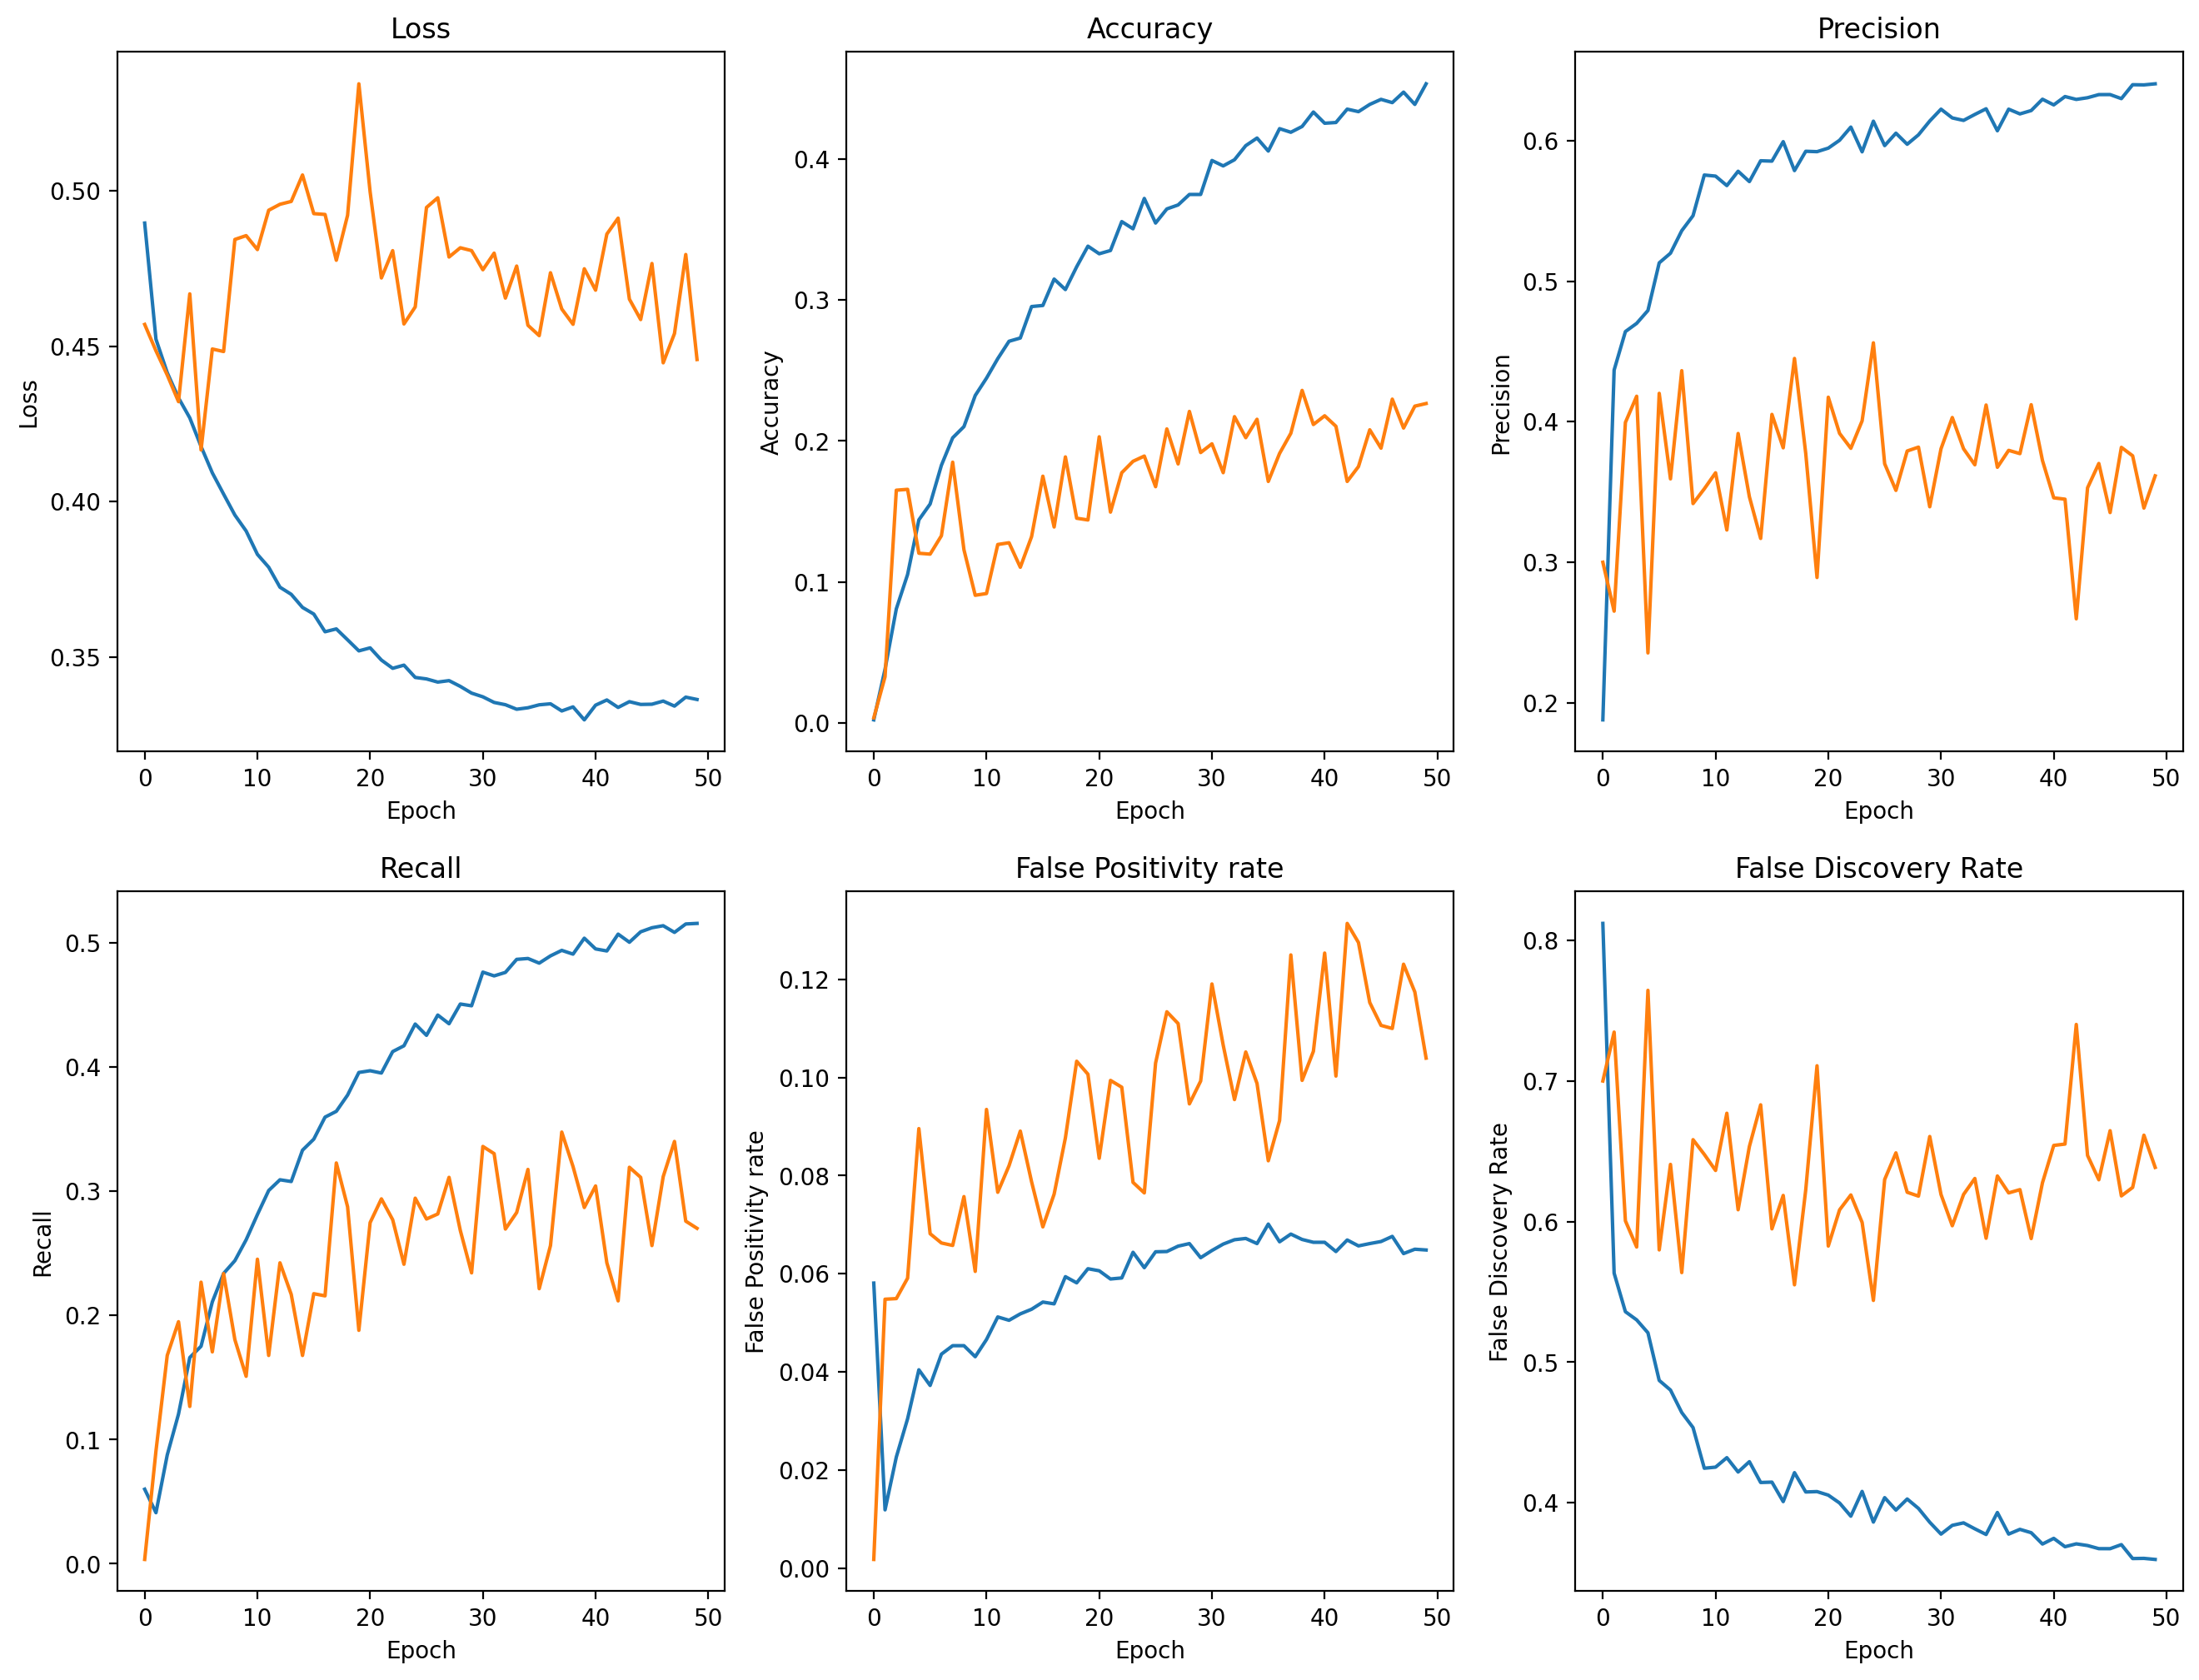

In [87]:

losses_val = torch.tensor(losses_val).cpu() 
X=  """
    ABC
    DEF
    """
fig, plot = plt.subplot_mosaic(X, figsize=(16, 12))
plot["A"].plot(range(len(losses)), losses)
plot["A"].plot(range(len(losses_val)), losses_val)
plot["A"].set_title("Loss")
plot["A"].set_xlabel("Epoch")
plot["A"].set_ylabel("Loss")

plot["B"].plot(accuracies)
plot["B"].plot(accuracies_val)
plot["B"].set_title("Accuracy")
plot["B"].set_xlabel("Epoch")
plot["B"].set_ylabel("Accuracy")

plot["C"].plot(precisions)
plot["C"].plot(precisions_val)
plot["C"].set_title("Precision")
plot["C"].set_xlabel("Epoch")
plot["C"].set_ylabel("Precision")

plot["D"].plot(recalls)
plot["D"].plot(recalls_val)
plot["D"].set_title("Recall")
plot["D"].set_xlabel("Epoch")
plot["D"].set_ylabel("Recall")

plot["E"].plot(fprs)
plot["E"].plot(fprs_val)
plot["E"].set_title("False Positivity rate")
plot["E"].set_xlabel("Epoch")
plot["E"].set_ylabel("False Positivity rate")

plot["F"].plot(fdrs)
plot["F"].plot(fdrs_val)
plot["F"].set_title("False Discovery Rate")
plot["F"].set_xlabel("Epoch")
plot["F"].set_ylabel("False Discovery Rate")


plt.show()

In [ ]:

X=  """
    ABC
    DEF
    """
fig, plot = plt.subplot_mosaic(X, figsize=(16, 12))
plot["A"].plot(range(len(losses)), losses)
plot["A"].set_title("Loss")
plot["A"].set_xlabel("Epoch")
plot["A"].set_ylabel("Loss")

plot["B"].plot(accuracies)
plot["B"].set_title("Accuracy")
plot["B"].set_xlabel("Epoch")
plot["B"].set_ylabel("Accuracy")

plot["C"].plot(precisions)
plot["C"].set_title("Precision")
plot["C"].set_xlabel("Epoch")
plot["C"].set_ylabel("Precision")

plot["D"].plot(recalls)
plot["D"].set_title("Recall")
plot["D"].set_xlabel("Epoch")
plot["D"].set_ylabel("Recall")

plot["E"].plot(fprs)
plot["E"].set_title("False Positivity rate")
plot["E"].set_xlabel("Epoch")
plot["E"].set_ylabel("False Positivity rate")

plot["F"].plot(fdrs)
plot["F"].set_title("False Discovery Rate")
plot["F"].set_xlabel("Epoch")
plot["F"].set_ylabel("False Discovery Rate")


plt.show()

2 epochs at 396x396 takes 11 minutes

In [88]:
thresh_class = 0.375
def evaluate_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():  # Disable gradient calculation
        correct = 0
        correct_multi = 0
        total = 0
        total_multi = 0
        loss = 0
        TPs = 0
        FPs = 0
        FNs = 0
        TNs = 0
        full_negatives = 0
        miss_negatives = 0
        lookout_negatives = []

        TPcorrect_cream = 0
        TPcorrect_dark = 0
        TPcorrect_lav = 0 
        TPcorrect_olive = 0
        TPcorrect_red = 0
        TPcorrect_yellow = 0

        TNcorrect_cream = 0
        TNcorrect_dark = 0
        TNcorrect_lav = 0 
        TNcorrect_olive = 0
        TNcorrect_red = 0
        TNcorrect_yellow = 0

        FPincorrect_cream = 0
        FPincorrect_dark = 0
        FPincorrect_lav = 0
        FPincorrect_olive = 0
        FPincorrect_red = 0
        FPincorrect_yellow = 0

        FNincorrect_cream = 0
        FNincorrect_dark = 0
        FNincorrect_lav = 0
        FNincorrect_olive = 0
        FNincorrect_red = 0
        FNincorrect_yellow = 0

        indiv_labels = 0
        indiv_total = 0

        criterion = nn.CrossEntropyLoss() #criterion = WeightedBCELoss(pos_weight=1.0, neg_weight=1.2)

        for images, labels in dataloader: # loop through batches
            images, labels = images.to(device), labels.to(device)
            #print(len(labels))
            #print(len(images))
            outputs = model(images)
            #print(outputs)
            loss += torch.sum(criterion(outputs, labels)).item()

            predicted = torch.sigmoid(outputs)
            predicted_labels = (predicted > thresh_class).int()
            #print(predicted)#, predicted, outputs) 
            #print(len(predicted_labels))
            labels = labels.int()
            total += labels.size(0) * len(base_color_labels)

            for items, prediction in zip(labels, predicted_labels): # loop through individual labels in batch
                if torch.equal(items, prediction): # increment correct if all labels are correct
                    correct += 1
                    if prediction[0] == 1:
                        TPcorrect_cream += 1
                    else:
                        TNcorrect_cream += 1
                    if prediction[1] == 1:
                        TPcorrect_dark += 1
                    else:
                        TNcorrect_dark += 1
                    if prediction[2] == 1:
                        TPcorrect_lav += 1
                    else:
                        TNcorrect_lav += 1
                    if prediction[3] == 1:
                        TPcorrect_olive += 1
                    else:
                        TNcorrect_olive += 1
                    if prediction[4] == 1:
                        TPcorrect_red += 1
                    else:
                        TNcorrect_red += 1
                    if prediction[5] == 1:
                        TPcorrect_yellow += 1
                    else:
                        TNcorrect_yellow += 1
                else: # increment incorrect if any label is incorrect
                    #print(item)
                    if prediction[0] == 1 and items[0] == 1:
                        TPcorrect_cream += 1
                    if prediction[0] == 0 and items[0] == 0:
                        TNcorrect_cream += 1
                    if prediction[1] == 1 and items[1] == 1:
                        TPcorrect_dark += 1
                    if prediction[1] == 0 and items[1] == 0:
                        TNcorrect_dark += 1
                    if prediction[2] == 1 and items[2] == 1:
                        TPcorrect_lav += 1
                    if prediction[2] == 0 and items[2] == 0:
                        TNcorrect_lav += 1
                    if prediction[3] == 1 and items[3] == 1:
                        TPcorrect_olive += 1
                    if prediction[3] == 0 and items[3] == 0:
                        TNcorrect_olive += 1
                    if prediction[4] == 1 and items[4] == 1:
                        TPcorrect_red += 1
                    if prediction[4] == 0 and items[4] == 0:
                        TNcorrect_red += 1
                    if prediction[5] == 1 and items[5] == 1:
                        TPcorrect_yellow += 1
                    if prediction[5] == 0 and items[5] == 0:
                        TNcorrect_yellow += 1
                    if prediction[0] == 1 and items[0] == 0:
                        FPincorrect_cream += 1
                    if prediction[0] == 0 and items[0] == 1:
                        FNincorrect_cream += 1
                    if prediction[1] == 1 and items[1] == 0:
                        FPincorrect_dark += 1
                    if prediction[1] == 0 and items[1] == 1:
                        FNincorrect_dark += 1
                    if prediction[2] == 1 and items[2] == 0:
                        FPincorrect_lav += 1
                    if prediction[2] == 0 and items[2] == 1:
                        FNincorrect_lav += 1
                    if prediction[3] == 1 and items[3] == 0:
                        FPincorrect_olive += 1
                    if prediction[3] == 0 and items[3] == 1:
                        FNincorrect_olive += 1
                    if prediction[4] == 1 and items[4] == 0:
                        FPincorrect_red += 1
                    if prediction[4] == 0 and items[4] == 1:
                        FNincorrect_red += 1
                    if prediction[5] == 1 and items[5] == 0:
                        FPincorrect_yellow += 1
                    if prediction[5] == 0 and items[5] == 1:
                        FNincorrect_yellow += 1


                if items.sum().item() > 1: # increment mutli-label correct
                    if torch.equal(items, prediction):
                        correct_multi += 1
                    total_multi += 1
                    """correct_multi += (prediction == items).sum().item()
                    total_multi += 6"""
                negatives_inLoop_check = abs(((prediction - 1) * items).sum().item())
                #print(f"negatives_inLoop_check: {negatives_inLoop_check}")
                if negatives_inLoop_check != 0:
                    if(items.sum().item() == 0):
                        full_negatives += 1
                    else: 
                        lookout_negatives.append(negatives_inLoop_check)
                        miss_negatives += 1
                    

                    #print(f"items: {items}, prediction: {prediction}")
                    #print(f"prediction: {items * (prediction - 1)}")
                    pass



            # Get number of correctly predicted labels
            #correct += (predicted_labels == labels).sum().item()

            
            indiv_labels += (predicted_labels == labels).sum().item()
            #print((predicted_labels == labels).sum().item())
            #rint(labels.size(0) * len(base_color_labels))
            #print(indiv_labels / (indiv_total + 1e-7))
            indiv_total += labels.size(0) * len(base_color_labels)
            #print(predicted_labels, labels) 
            #print((predicted_labels == labels).sum().item())


            """   correct += 1"""
            """if ((1 - predicted_labels) * labels).sum().item() != 0:
                if ((1 - predicted_labels) * labels).sum().item() == 6:
                    full_negatives += 1
                else:
                    lookout_negatives.append(((1 - predicted_labels) * labels).sum().item())
                    miss_negatives += 1
"""
            
            # Get discovery metrics
            TPs += (predicted_labels * labels).sum().item()
            FPs += abs((predicted_labels * (1 - labels)).sum().item())
            FNs += abs(((1 - predicted_labels) * labels).sum().item())
            TNs += ((1 - predicted_labels) * (1 - labels)).sum().item()
    

    assert(TPcorrect_cream + TPcorrect_dark + TPcorrect_lav + TPcorrect_olive + TPcorrect_red + TPcorrect_yellow == TPs)
    assert(TNcorrect_cream + TNcorrect_dark + TNcorrect_lav + TNcorrect_olive + TNcorrect_red + TNcorrect_yellow == TNs)
    assert(FPincorrect_cream + FPincorrect_dark + FPincorrect_lav + FPincorrect_olive + FPincorrect_red + FPincorrect_yellow == FPs)
    assert(FNincorrect_cream + FNincorrect_dark + FNincorrect_lav + FNincorrect_olive + FNincorrect_red + FNincorrect_yellow == FNs)

    precision = TPs / (TPs + FPs + 1e-7)
    recall = TPs / (TPs + FNs + 1e-7)
    false_positive_rate = FPs / (FPs + TNs  + 1e-7)
    false_discovery_rate = FPs / (FPs + TPs + 1e-7)
    false_negative_rate = FNs / (FNs + TPs + 1e-7)
        
    accuracy = 100 * correct / ( total / 6)
    if total_multi:
        accuracy_multi = 100 * correct_multi / total_multi
    else: 
        accuracy_multi = "N/A"
    loss /= len(dataloader.dataset)
    print(f'''
    ____________________________________________________________________________________________
    _____________________________________ MODEL EVALUATION _____________________________________\n
    ---[]---  Accuracy: {accuracy:.2f}%, {accuracy_multi}% (multiclasses)
    ---[]---  Loss: {loss}
    ---[]---  ---------------------------------------------------------------
    ---[]---  |\tTrue Positives: {TPs}\t|\tFalse Positives: {FPs}\t|
    ---[]---  |\tFalse Negatives: {FNs}\t|\tTrue Negatives : {TNs}\t|
    ---[]---  ---------------------------------------------------------------
    ---[]---  Total Labels: {int(total / 6)}
    ---[]---  Precision: {(precision * 100):.2f}%
    ---[]---  Recall: {(recall * 100):.2f}%
    ---[]---  False Positive Rate: {(false_positive_rate * 100):.2f}%
    ---[]---  False Discovery Rate: {(false_discovery_rate * 100):.2f}%
    ---[]---  False negative Rate: {(false_negative_rate * 100):.2f}%
    ---[]---  Correct: {correct}
    ---[]---  Number of Full Negatives : {full_negatives}
    ---[]---  Number of misclassified negatives : {miss_negatives}
    ---[]---  indiv accuracy : {((indiv_labels / (indiv_total + 1e-7)) * 100):.2f}
    ---[]---          \t\t\tCream\tDark\tLav\tOlive\tRed\tYellow
    ---[]---  true positives: \t\t{TPcorrect_cream}\t{TPcorrect_dark}\t{TPcorrect_lav}\t{TPcorrect_olive}\t{TPcorrect_red}\t{TPcorrect_yellow}
    ---[]---  false positives: \t\t{FPincorrect_cream}\t{FPincorrect_dark}\t{FPincorrect_lav}\t{FPincorrect_olive}\t{FPincorrect_red}\t{FPincorrect_yellow}
    ---[]---  false negatives: \t\t{FNincorrect_cream}\t{FNincorrect_dark}\t{FNincorrect_lav}\t{FNincorrect_olive}\t{FNincorrect_red}\t{FNincorrect_yellow}
    ---[]---  true negatives: \t\t{TNcorrect_cream}\t{TNcorrect_dark}\t{TNcorrect_lav}\t{TNcorrect_olive}\t{TNcorrect_red}\t{TNcorrect_yellow}
    ---[]---  Precisions: \t\t{TPcorrect_cream / (TPcorrect_cream + FPincorrect_cream + 1e-7):.2f}\t{TPcorrect_dark / (TPcorrect_dark + FPincorrect_dark + 1e-7):.2f}\t{TPcorrect_lav / (TPcorrect_lav + FPincorrect_lav + 1e-7):.2f}\t{TPcorrect_olive / (TPcorrect_olive + FPincorrect_olive + 1e-7):.2f}\t{TPcorrect_red / (TPcorrect_red + FPincorrect_red + 1e-7):.2f}\t{TPcorrect_yellow / (TPcorrect_yellow + FPincorrect_yellow + 1e-7):.2f}
    ---[]---  False Positivity Rates: \t{FPincorrect_cream / (FPincorrect_cream + TNcorrect_cream + 1e-7):.2f}\t{FPincorrect_dark / (FPincorrect_dark + TNcorrect_dark + 1e-7):.2f}\t{FPincorrect_lav / (FPincorrect_lav + TNcorrect_lav + 1e-7):.2f}\t{FPincorrect_olive / (FPincorrect_olive + TNcorrect_olive + 1e-7):.2f}\t{FPincorrect_red / (FPincorrect_red + TNcorrect_red + 1e-7):.2f}\t{FPincorrect_yellow / (FPincorrect_yellow + TNcorrect_yellow + 1e-7):.2f}
    ---[]---  False Discovery Rates: \t{FPincorrect_cream / (FPincorrect_cream + TPcorrect_cream + 1e-7):.2f}\t{FPincorrect_dark / (FPincorrect_dark + TPcorrect_dark + 1e-7):.2f}\t{FPincorrect_lav / (FPincorrect_lav + TPcorrect_lav + 1e-7):.2f}\t{FPincorrect_olive / (FPincorrect_olive + TPcorrect_olive + 1e-7):.2f}\t{FPincorrect_red / (FPincorrect_red + TPcorrect_red + 1e-7):.2f}\t{FPincorrect_yellow / (FPincorrect_yellow + TPcorrect_yellow + 1e-7):.2f}
    ---[]---  False Negativity Rates: \t{FNincorrect_cream / (FNincorrect_cream + TPcorrect_cream + 1e-7):.2f}\t{FNincorrect_dark / (FNincorrect_dark + TPcorrect_dark + 1e-7):.2f}\t{FNincorrect_lav / (FNincorrect_lav + TPcorrect_lav + 1e-7):.2f}\t{FNincorrect_olive / (FNincorrect_olive + TPcorrect_olive + 1e-7):.2f}\t{FNincorrect_red / (FNincorrect_red + TPcorrect_red + 1e-7):.2f}\t{FNincorrect_yellow / (FNincorrect_yellow + TPcorrect_yellow + 1e-7):.2f}''')

    model.train()  # Set the model back to training mode
    return accuracy, lookout_negatives

color_accuracy, lookout = evaluate_accuracy(model, gecko_dataloader_test, device)


    ____________________________________________________________________________________________
    _____________________________________ MODEL EVALUATION _____________________________________

    ---[]---  Accuracy: 18.51%, 2.3255813953488373% (multiclasses)
    ---[]---  Loss: 0.05710787350430644
    ---[]---  ---------------------------------------------------------------
    ---[]---  |	True Positives: 156	|	False Positives: 354	|
    ---[]---  |	False Negatives: 533	|	True Negatives : 2815	|
    ---[]---  ---------------------------------------------------------------
    ---[]---  Total Labels: 643
    ---[]---  Precision: 30.59%
    ---[]---  Recall: 22.64%
    ---[]---  False Positive Rate: 11.17%
    ---[]---  False Discovery Rate: 69.41%
    ---[]---  False negative Rate: 77.36%
    ---[]---  Correct: 119
    ---[]---  Number of Full Negatives : 0
    ---[]---  Number of misclassified negatives : 506
    ---[]---  indiv accuracy : 77.01
    ---[]---          			Cream	Dark	

In [76]:
for images, labels in gecko_dataloader_test:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.sigmoid(outputs)
    label = labels.int()
    print(predicted[0])
    print(label[0])
    print(predicted[1])
    print(label[1])
    print(predicted[2])
    print(label[2])
    print(predicted[3])
    print(label[3])
    print(predicted[4])
    print(label[4])
    print(predicted[5])
    print(label[5])
    print(predicted[6])
    print(label[6])
    print(predicted[7])
    print(label[7])
    print(predicted[8])
    print(label[8])
    print(predicted[9])
    print(label[9])
    print(predicted[10])
    print(label[10])

    break

tensor([0.1365, 0.2183, 0.2283, 0.4006, 0.2526, 0.1654], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0, 0, 1, 0, 0, 0], device='cuda:0', dtype=torch.int32)
tensor([0.2113, 0.7181, 0.1080, 0.1383, 0.1116, 0.0971], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
tensor([0.2307, 0.3388, 0.2168, 0.2536, 0.1748, 0.1027], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0, 0, 0, 1, 0, 0], device='cuda:0', dtype=torch.int32)
tensor([0.4482, 0.4949, 0.1568, 0.1153, 0.1730, 0.1112], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
tensor([0.8139, 0.0764, 0.0606, 0.0684, 0.0795, 0.1033], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0, 1, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)
tensor([0.1824, 0.1229, 0.3944, 0.2025, 0.1551, 0.2982], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor([0, 0, 1, 0, 0, 0], device='cu

In [ ]:
voidit =evaluate_accuracy(model, gecko_dataloader_test, device)

C:\Users\Ari Sinervo\AppData\Local\Temp\ipykernel_26436\3939766787.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(self.fc3(x))



    ____________________________________________________________________________________________
    _____________________________________ MODEL EVALUATION _____________________________________

    ---[]---  Accuracy: 24.61%, 0.0% (multiclasses)
    ---[]---  Loss: 0.015114203565504273
    ---[]---  ---------------------------------------------------------------
    ---[]---  |	True Positives: 246	|	False Positives: 525	|
    ---[]---  |	False Negatives: 424	|	True Negatives : 2609	|
    ---[]---  ---------------------------------------------------------------
    ---[]---  Total Labels: 634
    ---[]---  Precision: 31.91%
    ---[]---  Recall: 36.72%
    ---[]---  False Positive Rate: 16.75%
    ---[]---  False Discovery Rate: 68.09%
    ---[]---  False negative Rate: 63.28%
    ---[]---  Correct: 156
    ---[]---  Number of Full Negatives : 0
    ---[]---  Number of misclassified negatives : 406
    ---[]---
    ---[]---          			Cream	Dark	Lav	Olive	Red	Yellow
    ---[]---  tru

In [ ]:
voidit = evaluate_accuracy(model, gecko_dataloader_test, device)

C:\Users\Ari Sinervo\AppData\Local\Temp\ipykernel_26436\1255389259.py:64: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(self.fc4(x))



    ____________________________________________________________________________________________
    _____________________________________ MODEL EVALUATION _____________________________________

    ---[]---  Accuracy: 19.56%, 5.882352941176471% (multiclasses)
    ---[]---  Loss: 0.01595643764414622
    ---[]---  ---------------------------------------------------------------
    ---[]---  |	True Positives: 269	|	False Positives: 550	|
    ---[]---  |	False Negatives: 401	|	True Negatives : 2584	|
    ---[]---  ---------------------------------------------------------------
    ---[]---  Total Labels: 634
    ---[]---  Precision: 32.84%
    ---[]---  Recall: 40.15%
    ---[]---  False Positive Rate: 17.55%
    ---[]---  False Discovery Rate: 67.16%
    ---[]---  False negative Rate: 59.85%
    ---[]---  Correct: 124
    ---[]---  Number of Full Negatives : 0
    ---[]---  Number of misclassified negatives : 381
    ---[]---
    ---[]---          			Cream	Dark	Lav	Olive	Red	Yellow
    

In [ ]:
voidit = evaluate_accuracy(model, gecko_dataloader_test, device)

NameError: name 'evaluate_accuracy' is not defined

In [ ]:
voidit = evaluate_accuracy(model, gecko_dataloader_test, device)


    ____________________________________________________________________________________________
    _____________________________________ MODEL EVALUATION _____________________________________

    ---[]---  Accuracy: 17.19%, 11.764705882352942% (multiclasses)
    ---[]---  Loss: nan
    ---[]---  ---------------------------------------------------------------
    ---[]---  |	True Positives: 255	|	False Positives: 686	|
    ---[]---  |	False Negatives: 415	|	True Negatives : 2448	|
    ---[]---  ---------------------------------------------------------------
    ---[]---  Total Labels: 634
    ---[]---  Precision: 27.10%
    ---[]---  Recall: 38.06%
    ---[]---  False Positive Rate: 21.89%
    ---[]---  False Discovery Rate: 72.90%
    ---[]---  False negative Rate: 61.94%
    ---[]---  Correct: 109
    ---[]---  Number of Full Negatives : 0
    ---[]---  Number of misclassified negatives : 392
    ---[]---
    ---[]---          			Cream	Dark	Lav	Olive	Red	Yellow
    ---[]---  true 

In [ ]:
Base = torch.tensor([0, 0, 0, 1, 1, 1])

Test1 = torch.tensor([0, 0, 1, 1, 0, 0])
Test2 = torch.tensor([0, 1, 0, 1, 0, 0])
Test3 = torch.tensor([0, 0, 1, 0, 0, 1])

#(1 - predicted_labels) * labels).sum().item()

print(f"test one : {abs(((Test1) == (Base)).sum().item())}")
print(f"test one : {((Test2) * (Base - 1)).sum().item()}")
print(f"test one : {((Test3 - 1) * (Base - 1)).sum().item()}")
# only count positively if all the labels

# if one is off it's a total missmatch
4 

test one : 3
test one : -1
test one : 2


4

In [ ]:
for images, labels in gecko_dataloader_test:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    predicted = torch.sigmoid(outputs)
    label = labels.int()
    print(outputs)
    break

C:\Users\Ari Sinervo\AppData\Local\Temp\ipykernel_27620\3126571974.py:130: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(self.fc2(x))


tensor([[4.6266e-04, 1.3517e-02, 9.6085e-03, 4.3273e-04, 9.4252e-01, 3.3456e-02],
        [1.4120e-08, 5.1524e-08, 6.0216e-08, 1.9647e-09, 9.9983e-01, 1.6578e-04],
        [7.7929e-09, 2.0873e-06, 6.7266e-08, 3.0853e-08, 8.1626e-05, 9.9992e-01],
        [2.3163e-03, 3.7692e-03, 1.2537e-03, 1.3341e-03, 3.3828e-01, 6.5305e-01],
        [9.8380e-08, 2.3460e-01, 3.6677e-06, 1.3716e-05, 7.6538e-01, 1.0055e-06],
        [2.0598e-05, 5.4966e-01, 1.6491e-05, 1.3815e-04, 4.4985e-01, 3.1530e-04],
        [1.1002e-06, 8.5881e-07, 3.8813e-07, 1.8851e-07, 9.2039e-04, 9.9908e-01],
        [1.0020e-08, 4.3187e-06, 2.5785e-08, 1.9600e-09, 1.0000e+00, 3.6336e-08],
        [6.8914e-08, 9.9763e-01, 1.4344e-05, 2.2809e-06, 2.3462e-03, 3.4969e-06],
        [2.9448e-10, 6.9893e-04, 8.3931e-09, 4.9575e-10, 9.9930e-01, 5.1266e-08],
        [3.9772e-11, 9.9013e-01, 8.7946e-09, 5.4520e-09, 9.8674e-03, 7.0278e-08],
        [7.9018e-07, 1.3621e-05, 5.5833e-08, 9.0859e-09, 9.9998e-01, 1.1496e-06],
        [2.6021e

Save model to file to later check:

In [ ]:
#torch.save(model.state_dict(), "gecko_color_convnet_14(50ep).pth")

loaded_model = Gecko_Color_Alpha(num_classes)
loaded_model.load_state_dict(torch.load("gecko_color_Alpha_85(50ep).pth"))
loaded_model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
#criterion = WeightedBCELoss()
optimizer = torch.optim.SGD(loaded_model.parameters(), lr=0.001, momentum=0.9)
los, accs, precs, recs, fprs, fdrs= train(loaded_model, gecko_dataloader_train, criterion, optimizer, num_epochs=15)

C:\Users\Ari Sinervo\AppData\Local\Temp\ipykernel_17452\3634885598.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(self.fc3(x))


End Epoch [1/15], Loss: 1.1750881837435336, Precision: 0.8915339115255959, Accuracy: 0.8853995696100959
End Epoch [2/15], Loss: 1.1729258579857291, Precision: 0.8937250634715498, Accuracy: 0.887332676806361
End Epoch [3/15], Loss: 1.1710177598784102, Precision: 0.8950212133267033, Accuracy: 0.8892657840026261
End Epoch [4/15], Loss: 1.1683813540771377, Precision: 0.8979125896901575, Accuracy: 0.8920742604953131
End Epoch [5/15], Loss: 1.1675658813018086, Precision: 0.8979998550587072, Accuracy: 0.8924389977021556
End Epoch [6/15], Loss: 1.1658189688986351, Precision: 0.8995832578333046, Accuracy: 0.8942262100156837
End Epoch [7/15], Loss: 1.163961165287948, Precision: 0.9002606617880665, Accuracy: 0.8949556844293687
End Epoch [8/15], Loss: 1.1608154427351445, Precision: 0.9029474676398399, Accuracy: 0.8981288981288982
End Epoch [9/15], Loss: 1.160121917029106, Precision: 0.9032351555957568, Accuracy: 0.898858372542583
End Epoch [10/15], Loss: 1.1587593348190415, Precision: 0.9049207673

In [ ]:
voidit = evaluate_accuracy(loaded_model, gecko_dataloader_test, device)

C:\Users\Ari Sinervo\AppData\Local\Temp\ipykernel_17452\3634885598.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(self.fc3(x))



    __________________________________________________________________________
    ____________________________ MODEL EVALUATION ____________________________

    ---[]---  Accuracy: 90.93%, N/A% (multiclasses)
    ---[]---  Loss: 0.003551131146562569
    ---[]---  ---------------------------------------------------------------
    ---[]---  |	True Positives: 6294	|	False Positives: 601	|
    ---[]---  |	False Negatives: 561	|	True Negatives : 33674	|
    ---[]---  ---------------------------------------------------------------
    ---[]---  Total Labels: 6855
    ---[]---  Precision: 91.28%
    ---[]---  Recall: 91.82%
    ---[]---  False Positive Rate: 1.75%
    ---[]---  False Discovery Rate: 8.72%
    ---[]---  False negative Rate: 8.18%
    ---[]---  Correct: 6233
    ---[]---  Number of Full Negatives : 0
    ---[]---  Number of misclassified negatives : 561



In [ ]:
#torch.save(loaded_model.state_dict(), "gecko_color_Alpha_90(70ep).pth")


In [ ]:

class Gecko_Color_Alpha(nn.Module):
    def __init__(self, num_classes):
        super(Gecko_Color_Alpha, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.elu1 = nn.ELU()

        self.conv2 = nn.Conv2d(128, 192, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(192)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.elu2 = nn.ELU()

        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.elu3 = nn.ELU()
        
        conv_size = im_size // 2 // 2 // 2 
        self.fc1 = nn.Linear(384 * conv_size * conv_size, 196)
        self.bn4 = nn.BatchNorm1d(196)
        self.fc2 = nn.Linear(196, 128)
        self.bn5 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(128, 6)

    def forward(self, x):
        x = self.pool1(self.elu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.elu2(self.bn2(self.conv2(x))))
        x = self.pool3(self.elu3(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.bn4(self.fc1(x)))
        x = nn.functional.relu(self.bn5(self.fc2(x)))
        x = nn.functional.softmax(self.fc3(x))
        return x

In [ ]:
reloaded = Original(6)
reloaded.load_state_dict(torch.load("gecko_color_Alpha_90(70ep).pth"))
reloaded.to(device)


voidit = evaluate_accuracy(reloaded, gecko_dataloader_test, device)

C:\Users\Ari Sinervo\AppData\Local\Temp\ipykernel_22088\1132527450.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reloaded.load_state_dict(torch.load("gecko_color_Alpha


    ____________________________________________________________________________________________
    _____________________________________ MODEL EVALUATION _____________________________________

    ---[]---  Accuracy: 22.40%, 0.0% (multiclasses)
    ---[]---  Loss: 0.022270012776182277
    ---[]---  ---------------------------------------------------------------
    ---[]---  |	True Positives: 308	|	False Positives: 584	|
    ---[]---  |	False Negatives: 361	|	True Negatives : 2551	|
    ---[]---  ---------------------------------------------------------------
    ---[]---  Total Labels: 634
    ---[]---  Precision: 34.53%
    ---[]---  Recall: 46.04%
    ---[]---  False Positive Rate: 18.63%
    ---[]---  False Discovery Rate: 65.47%
    ---[]---  False negative Rate: 53.96%
    ---[]---  Correct: 142
    ---[]---  Number of Full Negatives : 0
    ---[]---  Number of misclassified negatives : 343
    ---[]---
    ---[]---          			Cream	Dark	Lav	Olive	Red	Yellow
    ---[]---  tru

In [ ]:
def Guess(model, path):
    image = Image.open(path)
    image = transform(image)
    image = image.unsqueeze(0)
    image = image.to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        predicted = torch.sigmoid(outputs)
        predicted_labels = (predicted >= thresh_class).int()
        print(predicted_labels[0])
        print(predicted)

        predicted_list = predicted_labels[0].tolist()

        if predicted_list[0] == 1:
            print("This one should be Cream!")
        elif predicted_list[1] == 1:
            print("This one should be Dark!")
        elif predicted_list[2] == 1:
            print("This one should be Lavender!")
        elif predicted_list[3] == 1:
            print("This one should be Olive!")
        elif predicted_list[4] == 1:
            print("This one should be Red!")
        elif predicted_list[5] == 1:
            print("This one should be Yellow!")
        return predicted_labels

In [ ]:
Guess(reloaded, "data/.jpeg")

tensor([0, 0, 0, 0, 1, 0], device='cuda:0', dtype=torch.int32)
tensor([[0.5070, 0.5134, 0.5003, 0.5070, 0.6581, 0.5584]], device='cuda:0')
This one should be Red!


C:\Users\Ari Sinervo\AppData\Local\Temp\ipykernel_14576\3203297492.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(self.fc3(x))


tensor([[0, 0, 0, 0, 1, 0]], device='cuda:0', dtype=torch.int32)